# Computational Physics - Exercise 3: Gross-Pitaevskii equation

The main goal of this exercise is to solve the Gross-Pitaevskii (GP) equation by exploiting different methods and procedures. In particular, this equation is very widely used to describe a diluted gas of bosonic atoms. By assumption this gas is cold, thus meaning that the temperature $ T $ is sufficiently low, so that we can only take into account $ s$-states having orbital angular momentum quantun number $ l = 0 $.
Moreover the spin degrees of freedom can be neglected, so that we are dealing with spinless ($ s = 0 $) bosons interacting each other by means of an effective interaction potential of the type: 
$$
v(\vec{r}, \vec{r}') = 4\pi\frac{\hbar^2}{m} a \delta(\vec{r}-\vec{r}'),
$$
where $ a $ represents the scattering length, from which we can infer the scattering properties of the system.
In order to compute the ground state ($ l = 0 $) of a system of $ N $ bosons, we can make use of the mean field approximation, so that the wave function describing the entire system can be written as a product of single-particle solutions $ \phi^{n}_{i} $, $ i = 1,...,N $. By considering only one single-particle function $ \phi^{n} = \phi^{n}(r) $ and by applying the variational method, we then obtain the so-called Hartree equation.
Then, by plugging the contact potential $ v(\vec{r}, \vec{r}') $ into the Hartree equation and by expressing energies in units of $ \hbar \omega $ (i.e. $ \tilde{E} = \frac{E}{\hbar \omega} $) and lengths in units of $ a_{h.o.} = \sqrt{\frac{\hbar}{m \omega}} $ (i.e. $ \tilde{r} = \frac{r}{a_{h.o.}} $), we finally get the aforementioned Gross-Pitaevskii equation:
$$
-\frac{1}{2}\frac{d^2\phi^n(r)}{dr^2} + \frac{1}{2}r^2\phi^n(r) + Na\left(\frac{\phi^n(r)}{r}\right)^2\phi^n(r) = \mu \phi^n(r),
$$
with $ Na $ being the only free parameter of the problem, so that if $ Na > 0 $ the internal potential is repulsive, while if $ Na < 0 $ it is attractive. 
Furthermore $ n $ is the principal quantun number describing the ground state ($ n = 0 $) and the excited states ($ n > 0 $) by using as basis of our wave function the one of the 3D harmonic oscillator. We can also define the radial density of the system as:
$$
\rho^{n}(r) = \left(\frac{\phi^{n}(r)}{r}\right)^2,
$$

and the interaction potential as: 
$$
v_{int}^{n}(r) \equiv v^{n}(r) = Na\left(\frac{\phi^n(r)}{r}\right)^2\phi^n(r).
$$

In [1]:
# Initialization
import numpy as np
from scipy.integrate import quad
from scipy.integrate import simpson
import matplotlib.pyplot as plt
import matplotlib.pyplot as pl
import scipy.constants as sp
import math
from scipy.linalg import eigh
from pylab import xlabel,ylabel

# 1) Flowchart

We propose a flowchart which helps us building up the code for the following points of the exercise. We explicitely consider the mixing procedure for the potential. See the attached file. 

# 2) GP equation after 1 iteration

In this section we solve only one iteration of the Gross-Pitaevskii equation for the ground state of cold bosons ($ l = 0 $) through the Numerov algorithm with the purpose of finding out the wave function (and consequently the density) and through the bisection method in order to compute the corresponding energy.

In the following cell we define some functions that we will use in the simulation. Firstly, we propose a function which implements the bisection method. We will exploit it to find the optimal value of $\mu$, namely the eigenvalue of the single particle problem: it takes the last value of the single particle wavefunction for two initial values of $\mu$ and goes on bisecting until a tolerance of $10^{-6}$ is reached.

The function "Numerof_last_value" implements the Numerov algorithm and returns the value of the wavefunction at the last point of the mesh. We discretize our mesh in 600 points equally spaced by h = 0.01, so as to cover a maximum distance from the origin equal to 6 (adimensional distance). Since we are considering a bound state, we have to put the value of the wavefunction at the origin equal to zero, whereas its value at the following point of the mesh is equal to h. Indeed:

$$
\phi(r) \simeq r^{l+1} = r \qquad \text{for } r \rightarrow 0 \text{ and } l=0
$$

To write the Numerov algorithm, we note that the GP equation can be recasted as follows:

$$
\dfrac{d^{2}}{dr^{2}} \phi(r) + k^{2}(r) \phi(r) = 0, \qquad k^{2}(r) = -r^{2} + 2 \mu - 2 v(r)
$$

By discretizing the space, the solution at each point of the mesh is therefore given by:

$$
\phi(r_{i}) = \dfrac{\phi(r_{i-1})[2 - \dfrac{5}{6} h^{2} k^{2}(r_{i-1})] - \phi(r_{i-2})[1 + \dfrac{1}{12} h^{2} k^{2}(r_{i-2})]}{1 + \dfrac{1}{12} h^{2} k^{2}(r_{i})}
$$

The wavefunction thus obtained is not normalized, so we evaluate the norm $A$ in a discretized way:

$$
A = \int_{0}^{+\infty} d^{3}r |\psi(r)|^{2} = \int_{0}^{+\infty} dr 4 \pi r^{2} \dfrac{|\phi(r)|^{2}}{r^{2}} \dfrac{1}{4 \pi} = \int_{0}^{+\infty} dr |\phi(r)|^{2} \simeq \sum_{i=0}^{M-1} h |\phi(r_{i})|^{2}
$$

where M is the number of points in the mesh. Finally, the normalized wavefunction is obtained by dividing the one obtained through the Numerov method by $\sqrt{A}$.

The function "Numerov_rho_phi" implements again the Numerov algorithm, but returns the vectors for both the wavefunction and the corresponding density. For the density, we have to put the value at the origin equal to that at the subsequent point of the mesh, in order to avoid divergencies:

$$
\rho(0) = \rho(h)
$$

In [2]:
M = 600
h = 0.01

def bisection_phi(function, a, b, v):
    tolerance = 1e-6
    while abs(function(b,v) - function(a,v)) > tolerance:
        c = (a + b) / 2  # Calculate the midpoint
        if abs(function(c,v)) < tolerance:
            return c  # Find a good approximation
        elif function(c,v) * function(a,v) < 0:
            b = c  # Update the right endpoint
        else:
            a = c  # Update the left endpoint
    return (a + b) / 2 

def Numerov_last_value(mu,v):    
    r = np.zeros(M, float)
    k = np.zeros(M, float)
    phi = np.zeros(M, float)
    r[0] = 0
    r[1] = h
    phi[0] = 0
    phi[1] = h
    k[0] = 2 * mu
    k[1] = -r[1]**2 + 2 * mu - 2 * v[1]

    for i in range(2, M):
        r[i] = r[0] + h * i
        k[i] = -r[i]**2 + 2 * mu - 2 * v[i]
        phi[i] = ((phi[i-1] * (2 - (5/6) * (h**2) * k[i-1])) - (phi[i-2] * (1 + ((h**2)*k[i-2])/12))) / ((1 + ((h**2)*k[i])/12))
    
    norm = 0
    for i in range(M):
        norm += phi[i]**2 * h

    phi = phi / np.sqrt(norm)

    return phi[M-1]

def Numerov_rho_phi(mu,v):
    r = np.zeros(M, float)
    k = np.zeros(M, float)
    phi = np.zeros(M, float)
    r[0] = 0
    r[1] = h
    phi[0] = 0
    phi[1] = h
    k[0] = 2 * mu
    k[1] = -r[1]**2 + 2 * mu - 2 * v[1]

    for i in range(2, M):
        r[i] = r[0] + h * i
        k[i] = -r[i]**2 + 2 * mu - 2 * v[i]
        phi[i] = ((phi[i-1] * (2 - (5/6) * (h**2) * k[i-1])) - (phi[i-2] * (1 + ((h**2)*k[i-2])/12))) / ((1 + ((h**2)*k[i])/12))

    norm = 0
    for i in range(M):
        norm += phi[i]**2 * h

    phi = phi / np.sqrt(norm)
    rho = phi**2/r**2
    rho[0] = rho[1] # in order to avoid problems with the first point of the mesh 
    
    return rho, phi

If we specialize in the particular case of non interacting density, the interaction potential $v(r)$ is vanishing, so that the adimensional Gross-Pitaevskii equation assumes the form of a 3D harmonic oscillator equation. 
As a result, the energy of this specific system of non-interacting bosons (expressed in terms of the adimensional parameter $ \mu $) is equal to $ \mu = 3/2 $, i.e. the ground-state energy level of a 3D harmonic oscillator.
We also expect that the profile of the density of this system acquires a flat non vanishing trend for values of the position $ r $ close to the origin, thus reflecting the fact that at these values of $ r $ the particles are confined in an harmonic well. 

C:\Users\Hp\AppData\Local\Temp\ipykernel_11500\1962102331.py:61: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


Text(0, 0.5, '$\\rho$')

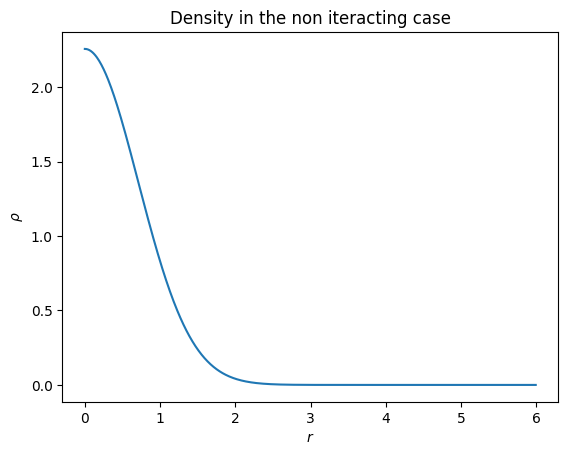

In [97]:
# Densità nel caso non interagente

M = 600
v0 = np.zeros(M, float)
mu_non_interacting = 1.5
h = 0.01

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

rho_non_interacting, phi_non_interacting = Numerov_rho_phi(mu_non_interacting,v0)

plt.plot(r,rho_non_interacting)
plt.title("Density in the non iteracting case")
xlabel(r'$r$')
ylabel(r'$\rho$')

We now analyze the problem by considering also the interacting internal potential $ v^{n}(r) $. Since we are examining only the ground state of the system ($ n = 0 $), then for sake of notation we can rewrite it as $ v^{n}(r) \equiv v(r) $. 
In this section we choose a fixed value of $ Na = 0.01 $ and we explicitly consider the so-called mixing procedure. This means that we start by setting as initial guess $ v_{0} = 0 $ (i.e. the internal potential in the non interacting case), then we set $ v_{1} = Na \rho $, with here $ \rho $ representing the density computed by means of the Numerov algorithm in the previous step (i.e. with the vanishing $ v_{0} $). We then write an iterative formula for the potential at the next step:
$$
v_{2} = \alpha v_{1} + (1 - \alpha)v_{0},
$$
where $ \alpha $ is a mixing parameter, which is firstly set to be $ \alpha = 0.1 $.
In this way we sum to our solution a not divergent piece at each iteration of the Numerov algorithm.
For instance, in the following cell we exploit the Numerov method (in order to find out the wave function and consequently also the density) and the bisection method (in order to get $ \mu $) after only one iteration on the potential $ v $.

C:\Users\Hp\AppData\Local\Temp\ipykernel_11500\1962102331.py:61: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


Optimal mu after just 1 iteration: 1.50079774166079


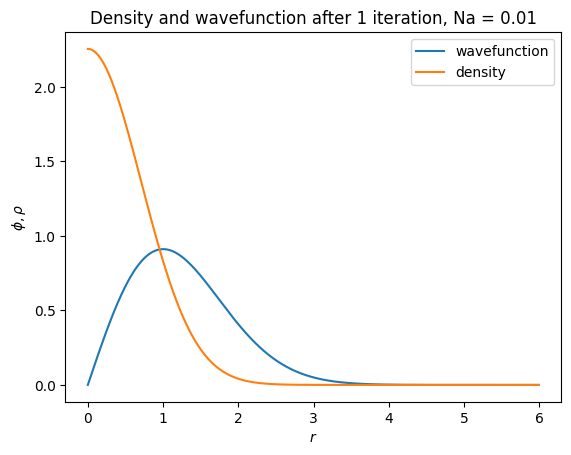

In [98]:
Na = 0.01
alpha = 0.1

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,2,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho
v2 = (alpha) * v1 + (1-alpha) * v0

optimal_mu = bisection_phi(Numerov_last_value, 1, 2, v2)
rho, phi = Numerov_rho_phi(optimal_mu,v2)

print("Optimal mu after just 1 iteration:", optimal_mu)
plt.plot(r,phi,label='wavefunction')
plt.plot(r,rho,label='density')
plt.title("Density and wavefunction after 1 iteration, Na = 0.01")
xlabel(r'$r$')
ylabel(r'$\phi,\rho$')
plt.legend()

In order to discuss the evolution of the various solutions with the parameter $ \alpha $ we decide to take 7 different values, i.e. $ \alpha = 0.01, 0.06, 0.2, 0.4, 0.5, 0.8, 1 $ and for each of these values we follow the usual approach of finding out the wave function and the energy (in terms of $ \mu $) after just one iteration of the mixing procedure.

C:\Users\Hp\AppData\Local\Temp\ipykernel_11500\1962102331.py:61: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


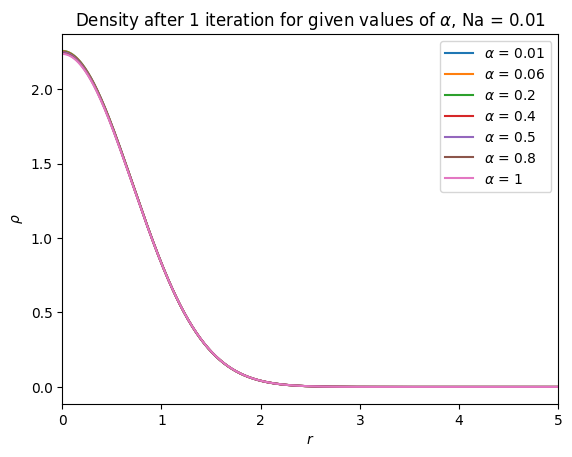

In [99]:
# Soluzioni dopo una sola iterazione per GP al variare di alpha

Na = 0.01
alpha = np.array([0.01, 0.06, 0.2, 0.4, 0.5, 0.8, 1],float)
M = 600
h = 0.01

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,2,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

v2_0 = (alpha[0]) * v1 + (1-alpha[0]) * v0
optimal_mu = bisection_phi(Numerov_last_value,1,2,v2_0)
rho_0, phi_0 = Numerov_rho_phi(optimal_mu,v2_0)

v2_1 = (alpha[1]) * v1 + (1-alpha[1]) * v0
optimal_mu = bisection_phi(Numerov_last_value,1,2,v2_1)
rho_1, phi_1 = Numerov_rho_phi(optimal_mu,v2_1)

v2_2 = (alpha[2]) * v1 + (1-alpha[2]) * v0
optimal_mu = bisection_phi(Numerov_last_value,1,2,v2_2)
rho_2, phi_2 = Numerov_rho_phi(optimal_mu,v2_2)

v2_3 = (alpha[3]) * v1 + (1-alpha[3]) * v0
optimal_mu = bisection_phi(Numerov_last_value,1,2,v2_3)
rho_3, phi_3 = Numerov_rho_phi(optimal_mu,v2_3)

v2_4 = (alpha[4]) * v1 + (1-alpha[4]) * v0
optimal_mu = bisection_phi(Numerov_last_value,1,2,v2_4)
rho_4, phi_4 = Numerov_rho_phi(optimal_mu,v2_4)

v2_5 = (alpha[5]) * v1 + (1-alpha[5]) * v0
optimal_mu = bisection_phi(Numerov_last_value,1,2,v2_5)
rho_5, phi_5 = Numerov_rho_phi(optimal_mu,v2_5)

v2_6 = (alpha[6]) * v1 + (1-alpha[6]) * v0
optimal_mu = bisection_phi(Numerov_last_value,1,2,v2_6)
rho_6, phi_6 = Numerov_rho_phi(optimal_mu,v2_6)

plt.plot(r,rho_0,label=r'$\alpha$ = 0.01')
plt.plot(r,rho_1,label=r'$\alpha$ = 0.06')
plt.plot(r,rho_2,label=r'$\alpha$ = 0.2')
plt.plot(r,rho_3,label=r'$\alpha$ = 0.4')
plt.plot(r,rho_4,label=r'$\alpha$ = 0.5')
plt.plot(r,rho_5,label=r'$\alpha$ = 0.8')
plt.plot(r,rho_6,label=r'$\alpha$ = 1')
plt.xlim([0,5])
plt.title("Density after 1 iteration for given values of " r'$\alpha$' ", Na = 0.01")
xlabel(r'$r$')
ylabel(r'$\rho$')
plt.legend()

By varying the parameter $ \alpha $ we note that the trend of the density $ \rho $ does not vary so much. Indeed we also add the following cell, containing a zoom of the plot of the 7 curves of $ \rho(r) $, thus emphasizing the fact that only for small values of the position $ r $ they are slightly different from each other.

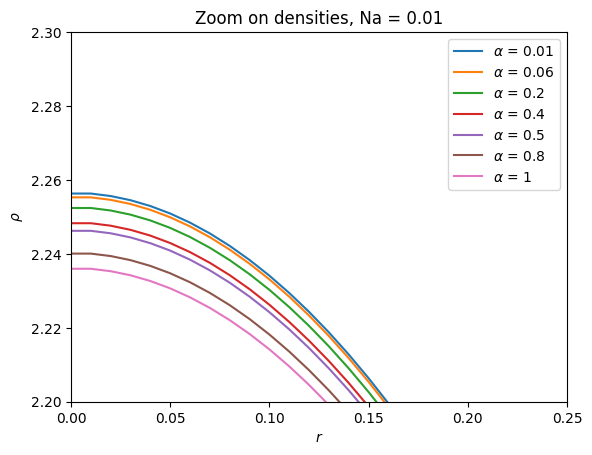

In [100]:
# Zoom sulle densità

plt.plot(r,rho_0,label=r'$\alpha$ = 0.01')
plt.plot(r,rho_1,label=r'$\alpha$ = 0.06')
plt.plot(r,rho_2,label=r'$\alpha$ = 0.2')
plt.plot(r,rho_3,label=r'$\alpha$ = 0.4')
plt.plot(r,rho_4,label=r'$\alpha$ = 0.5')
plt.plot(r,rho_5,label=r'$\alpha$ = 0.8')
plt.plot(r,rho_6,label=r'$\alpha$ = 1')
plt.xlim([0,0.25])
plt.ylim([2.2,2.3])
plt.title("Zoom on densities, Na = 0.01")
xlabel(r'$r$')
ylabel(r'$\rho$')
plt.legend()

# 3) Solution of GP equation through comparison between 2 methods

An alternative way of the bisection method to compute $ \mu $ (which we have already used in the previous section) consists of implementing the so-called self-consistent procedure. In particular, we can estimate the energy by the expectation value of the GP Hamiltonian $ H $, i.e. :
$$
E = \langle\phi| H |\phi\rangle,
$$
where $ \phi = \phi(r) $ represents the usual single-particle wave function. More specifically, since we are only analyzing the ground state of the system, then $ l = 0 $, so that our single-particle solution reads:
$$
\phi(\vec{r}) = \frac{\phi^{n,l}(r)}{r} Y^{l,m}(\theta,\phi) = \frac{1}{\sqrt{4\pi}}\frac{\phi^{n,0}(r)}{r}.
$$
After some mathematical manipulations, we then obtain the expression of the energy related to the already mentioned Hartree equation, which is satisfied by the solution $ \phi $ that minimizes $ \langle\phi| H |\phi\rangle $.
In terms of the Gross-Pitaevskii equation, we have to adopt the adimensional variables that we introduced before and by doing this we get:
$$
E^H = E_{kin} + E_{ext} + E_{int},
$$
where:
$$
E_{kin} = -\frac{1}{2} \int dr \phi(r) \frac{d^2}{dr^2}\phi(r)
$$

$$
E_{ext} = \frac{1}{2} \int  r^2 dr \left|\phi(r)\right|^2
$$

$$
E_{int} = \frac{Na}{2} \int dr \rho(r) \left| \phi(r) \right|^2.
$$
In the case of the $ E_{kin} $ contribution, we make use of the integration by parts in order to rewrite it in terms of first derivatives, rather than second derivatives. In this way we get:
$$
E_{kin} = -\frac{1}{2} \int dr \phi(r) \frac{d^2}{dr^2}\phi(r) = +\frac{1}{2} \int dr \frac{d}{dr} \phi(r) \frac{d}{dr} \phi(r).
$$
The term of the integration by parts evaluated at the boundaries, i.e. at $ r = 0 $ and at $ r = +\infty$ is vanishing since at these two points the wave function must tend to zero (indeed we are examining a bound state solution). 
In terms of $ \mu $ the above equation reads:
$$
\mu = E_{kin} + E_{ext} + 2E_{int},
$$
so that if
$$
\mu - E_{int} = E^{H}
$$
then we have reached convergence. This is the spirit of the self-consistent procedure.
If everything works well, we should get the same values of $\mu$ from the two methods, i.e. the bisection method and the self-consistent procedure.
In this section we specialize to only one fixed value of the free parameter, i.e. $ Na = 0.01 $ and we extract $ \mu $ by performing $ N = 100 $ iterations in the case of the bisection method.

## Case Na = 0.01

In [90]:
# Metodo di bisezione

Na = 0.01
alpha = 0.1
M = 600
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,2,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1
mu_2 = 2

v_mat = np.zeros([M,N],float) # matrice dove salviamo il potenziale (vettore che contiene il corrispondente valore ad ogni punto del mesh) ad ogni iterazione
mu_vec = np.zeros(N, float) # vettore dove salviamo i valori di mu ottenuti ad ogni iterazione
mu_vec[0] = mu_optimal # il primo mu è quello della prima iterazione
rho_mat = np.zeros([M,N],float) # matrice dove salviamo la funzine d'onda (vettore che contiene il corrispondente valore ad ogni punto del mesh) ad ogni iterazione
phi_mat = np.zeros([M,N],float) # matrice dove salviamo la densità (vettore che contiene il corrispondente valore ad ogni punto del mesh) ad ogni iterazione

for m in range(1,N): # indice che scorre sulle iterazioni
    v2 = (1-alpha) * v0 + (alpha) * v1 # potenziale da usare per la bisezione, ottenuto con la procedura di mixing
    v_mat[:,m] = v2 # salvo il potenziale nella sua matrice
    mu_vec[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2) # trovo il mu corrispondente applicando la bisezione al valore della funzione d'onda all'ulitmo punto del mesh
    rho_mat[:,m], phi_mat[:,m] = Numerov_rho_phi(mu_vec[m],v2) # trovo le corrispondenti densità e funzione d'onda
    v0 = v2 # aggiorno: il vecchio potenziale v_old è quello che ho usato per trovare mu in questa iterazione 
    v1 = Na * rho_mat[:,m] # aggiorno: il nuovo potenziale v_new lo costruisco dalla densità ottenuta con Numerov 2 righe sopra
    print(m) # stampo il numero dell'iterazione per controllare tutte le iterazioni

C:\Users\Hp\AppData\Local\Temp\ipykernel_11500\1962102331.py:61: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0, 0.5, '$\\mu$')

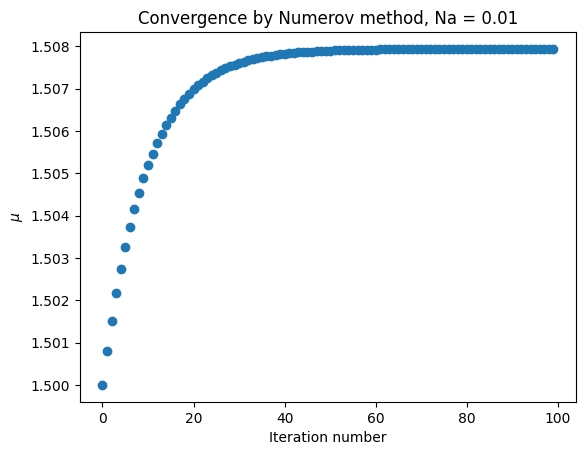

In [91]:
# Stampo i valori di mu ottenuti in funzione delle iterazioni

plt.scatter(range(N),mu_vec)
plt.title("Convergence by Numerov method, Na = 0.01")
xlabel("Iteration number")
ylabel(r'$\mu$')

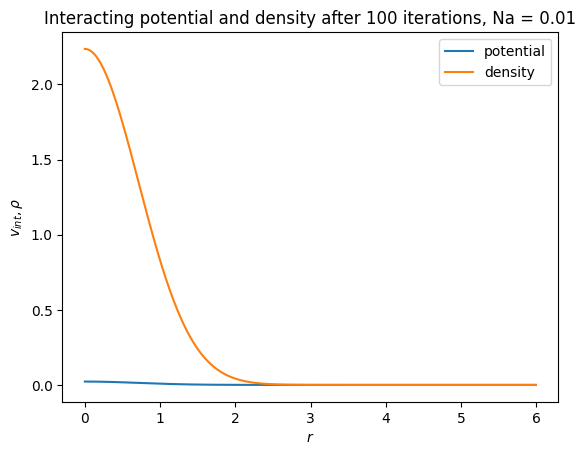

In [92]:
# Stampo potenziale e densità all'ultima iterazione

plt.plot(r,v_mat[:,N-1],label="potential")
plt.plot(r[:],rho_mat[:,N-1],label="density")
plt.title("Interacting potential and density after 100 iterations, Na = 0.01")
xlabel(r'$r$')
ylabel(r'$v_{int},\rho$')
plt.legend()

In order to perform the integrals for the functional way of evaluating $\mu$, we discretize the above expressions:

$$
E_{kin} = \frac{1}{2} \int dr \frac{d}{dr} \phi(r) \frac{d}{dr} \phi(r) \simeq \dfrac{1}{2} h \sum_{i=0}^{M-1} \left|\dfrac{d}{dr} \phi(r_{i})\right|^{2}, \qquad \dfrac{d}{dr} \phi(r_{i}) = \dfrac{\phi(r_{i}) - \phi(r_{i-1})}{h}
$$

$$
E_{ext} = \frac{1}{2} \int  r^2 dr \left|\phi(r)\right|^2 \simeq \dfrac{1}{2} h \sum_{i=0}^{M-1} |\phi(r_{i})|^{2} r_{i}^{2}
$$

$$
E_{int} = \frac{Na}{2} \int dr \rho(r) \left| \phi(r) \right|^2 \simeq \dfrac{1}{2} Na h \sum_{i=0}^{M-1} \rho(r_{i}) \left| \phi(r_{i}) \right|^2
$$

Text(0, 0.5, '$\\mu$')

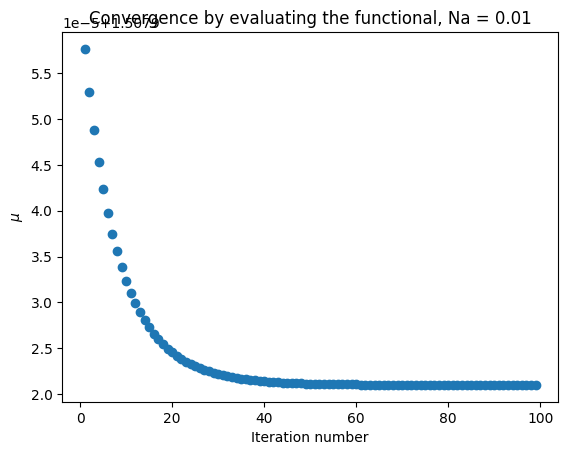

In [93]:
# Metodo che usa il funzionale per calcolare mu

E_int2 = np.zeros(N) # vettore delle energie di interazione ad ogni iterazione
E_ext2 = np.zeros(N) # vettore delle energie esterne ad ogni iterazione
E_kin2 = np.zeros(N) # vettore delle energie cinetiche ad ogni iterazione
mu_found2 = np.zeros(N) # vettore dei valori di mu ad ogni iterazione
dev_prime = np.zeros([M,N],float) # matrice delle derivate prime: sulle righe i punti del mesh, sulle colonne le iterazioni
for m in range(N): # riempio tutte le matrici
    for i in range(1,M-1):
        dev_prime[i][m] = (phi_mat[i][m] - phi_mat[i-1][m]) / (h) 
for m in range(N):
    for i in range(M):
        E_kin2[m] += 0.5 * dev_prime[i][m]**2 * h 
        E_ext2[m] += 0.5 * phi_mat[i][m]**2 *r[i]**2 * h 
        E_int2[m] += 0.5 * Na * phi_mat[i][m]**2 * rho_mat[i][m] *h 
        mu_found2[m] = (2*E_int2[m] + E_ext2[m] + E_kin2[m]) # trovo mu dalla formula di cui sopra

plt.scatter(range(1,N),mu_found2[1:])
plt.title("Convergence by evaluating the functional, Na = 0.01")
xlabel("Iteration number")
ylabel(r'$\mu$')

Text(0, 0.5, 'Difference')

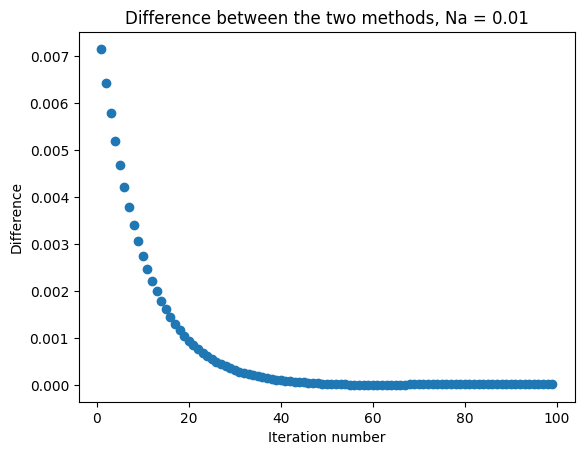

In [94]:
difference = mu_vec - mu_found2
plt.scatter(range(1,N),abs(difference[1:]))
plt.title("Difference between the two methods, Na = 0.01")
xlabel("Iteration number")
ylabel("Difference")

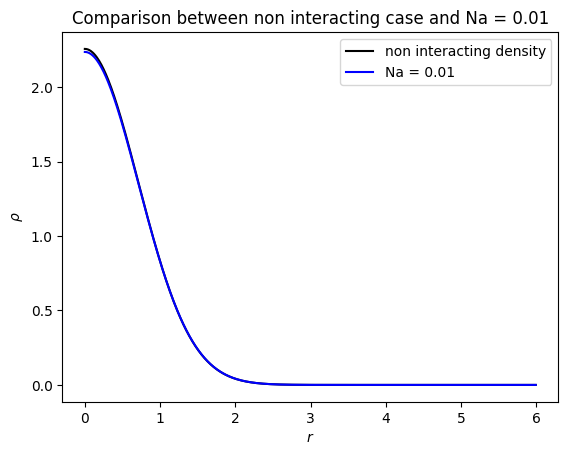

In [101]:
# Comparison between the resulting density and the non interacting particle case

plt.plot(r,rho_non_interacting,color = 'k', label = 'non interacting density')
plt.plot(r[:],rho_mat[:,N-1],color = 'b', label = 'Na = 0.01')
xlabel(r'$r$')
ylabel(r'$\rho$')
plt.title("Comparison between non interacting case and Na = 0.01")
plt.legend(loc='upper right')

# 4) Solutions of GP equation for different values of Na

In this section we vary Na = 0.01, 0.1, 1, 10, 100, in order to see how the solutions change. Then we compare the resulting density to the one of the non interacting particle case. We see that the more Na, the more the difference between the non interacting and the interacting case densities. We also plot the difference between $\mu$ obtained by the functional, computed in the previous section, and by Numerov for each value of Na.

## Case Na = 0.1

In [102]:
Na = 0.1
alpha = 0.1
M = 600
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,2,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1
mu_2 = 4

v_mat_01 = np.zeros([M,N],float)
mu_vec_01 = np.zeros(N, float)
mu_vec_01[0] = mu_optimal
rho_mat_01 = np.zeros([M,N],float)
phi_mat_01 = np.zeros([M,N],float)

for m in range(1,N):
    v2 = (1-alpha) * v0 + (alpha) * v1    
    v_mat_01[:,m] = v2
    mu_vec_01[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2)
    rho_mat_01[:,m], phi_mat_01[:,m] = Numerov_rho_phi(mu_vec_01[m],v2)
    v0 = v2
    v1 = Na * rho_mat_01[:,m]
    print(m)

C:\Users\Hp\AppData\Local\Temp\ipykernel_11500\1962102331.py:61: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0, 0.5, '$\\mu$')

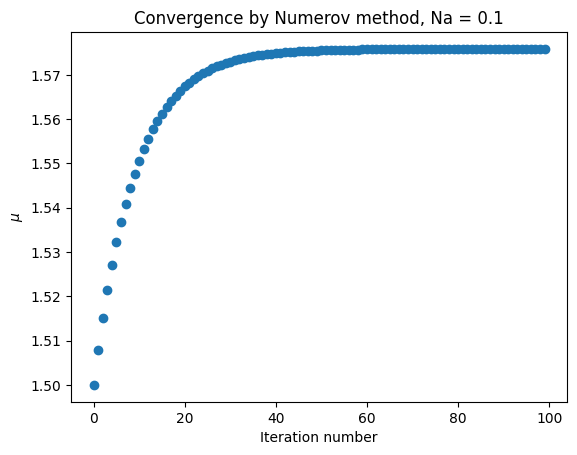

In [103]:
plt.scatter(range(N),mu_vec_01)
plt.title("Convergence by Numerov method, Na = 0.1")
xlabel("Iteration number")
ylabel(r'$\mu$')

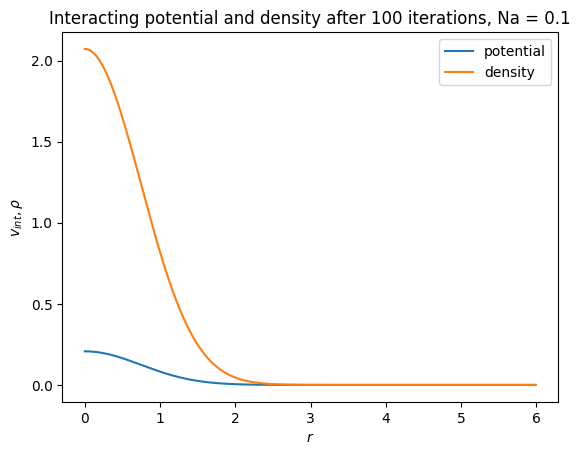

In [104]:
plt.plot(r,v_mat_01[:,N-1],label="potential")
plt.plot(r[:],rho_mat_01[:,N-1],label="density")
plt.title("Interacting potential and density after 100 iterations, Na = 0.1")
xlabel(r'$r$')
ylabel(r'$v_{int},\rho$')
plt.legend()

Text(0, 0.5, '$\\mu$')

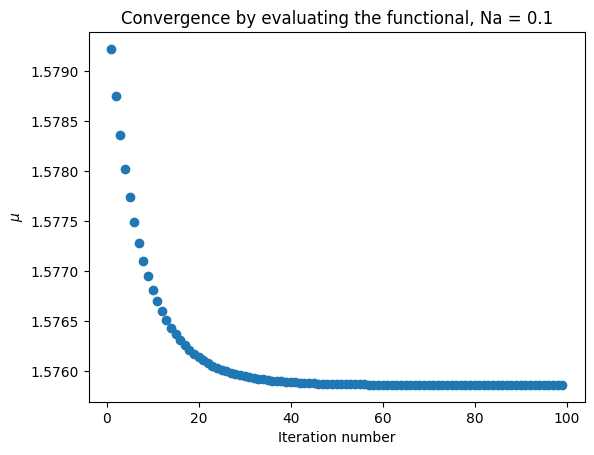

In [105]:
E_int2 = np.zeros(N)
E_ext2 = np.zeros(N)
E_kin2 = np.zeros(N)
mu_found2 = np.zeros(N)
dev_prime = np.zeros([M,N],float)
for m in range(N):
    for i in range(1,M-1):
        dev_prime[i][m] = (phi_mat_01[i][m] - phi_mat_01[i-1][m]) / (h) 
for m in range(N):
    for i in range(M):
        E_kin2[m] += 0.5 * dev_prime[i][m]**2 * h 
        E_ext2[m] += 0.5 * phi_mat_01[i][m]**2 *r[i]**2 * h 
        E_int2[m] += 0.5 * Na * phi_mat_01[i][m]**2 * rho_mat_01[i][m] *h 
        mu_found2[m] = (2*E_int2[m] + E_ext2[m] + E_kin2[m])

plt.scatter(range(1,N),mu_found2[1:])
plt.title("Convergence by evaluating the functional, Na = 0.1")
xlabel("Iteration number")
ylabel(r'$\mu$')

Text(0, 0.5, 'Difference')

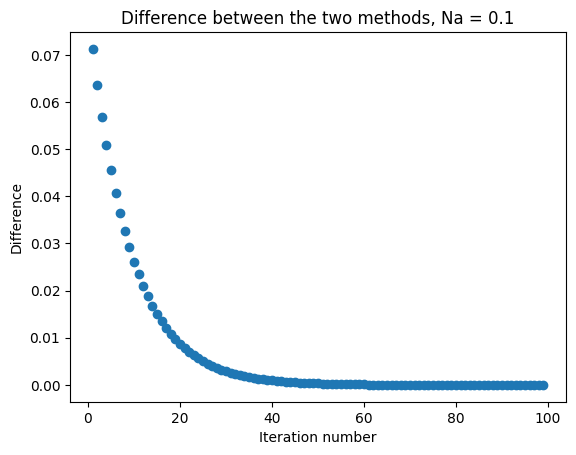

In [106]:
difference = mu_vec_01 - mu_found2
plt.scatter(range(1,N),abs(difference[1:]))
plt.title("Difference between the two methods, Na = 0.1")
xlabel("Iteration number")
ylabel("Difference")

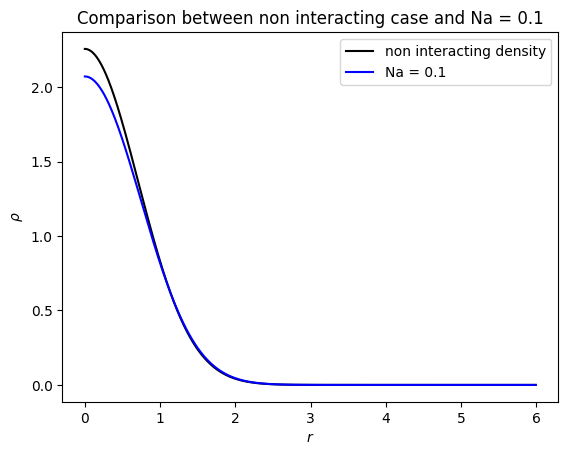

In [107]:
# Comparison between the resulting density and the non interacting particle case

plt.plot(r,rho_non_interacting,color = 'k', label = 'non interacting density')
plt.plot(r[:],rho_mat_01[:,N-1],color = 'b', label = 'Na = 0.1')
xlabel(r'$r$')
ylabel(r'$\rho$')
plt.title("Comparison between non interacting case and Na = 0.1")
plt.legend(loc='upper right')

## Case Na = 1

In [108]:
Na = 1
alpha = 0.1
M = 600
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,6,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1.4
mu_2 = 2.5

v_mat_1 = np.zeros([M,N],float)
mu_vec_1 = np.zeros(N, float)
mu_vec_1[0] = mu_optimal
rho_mat_1 = np.zeros([M,N],float)
phi_mat_1 = np.zeros([M,N],float)

for m in range(1,N):
    v2 = (1-alpha) * v0 + (alpha) * v1    
    v_mat_1[:,m] = v2
    mu_vec_1[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2)
    rho_mat_1[:,m], phi_mat_1[:,m] = Numerov_rho_phi(mu_vec_1[m],v2)
    v0 = v2
    v1 = Na * rho_mat_1[:,m]
    print(m)

C:\Users\Hp\AppData\Local\Temp\ipykernel_11500\1962102331.py:61: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0, 0.5, '$\\mu$')

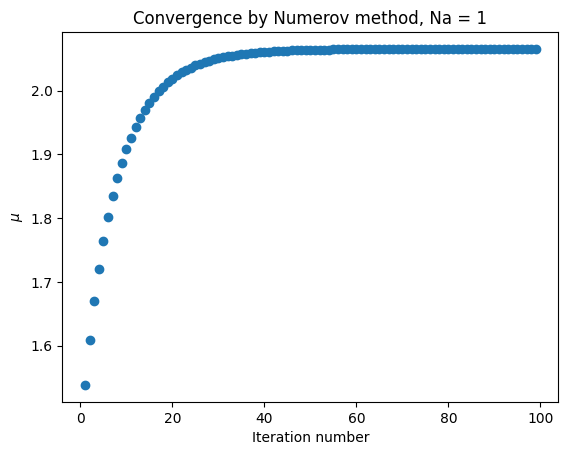

In [109]:
plt.scatter(range(1,N),mu_vec_1[1:])
plt.title("Convergence by Numerov method, Na = 1")
xlabel("Iteration number")
ylabel(r'$\mu$')

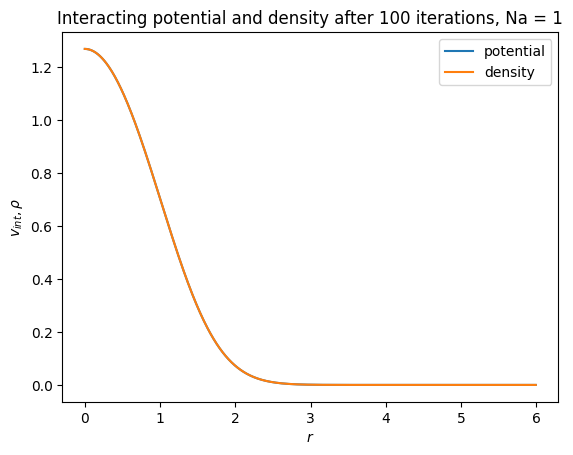

In [110]:
plt.plot(r,v_mat_1[:,N-1],label="potential")
plt.plot(r[:],rho_mat_1[:,N-1],label="density")
plt.title("Interacting potential and density after 100 iterations, Na = 1")
xlabel(r'$r$')
ylabel(r'$v_{int},\rho$')
plt.legend()

Text(0, 0.5, '$\\mu$')

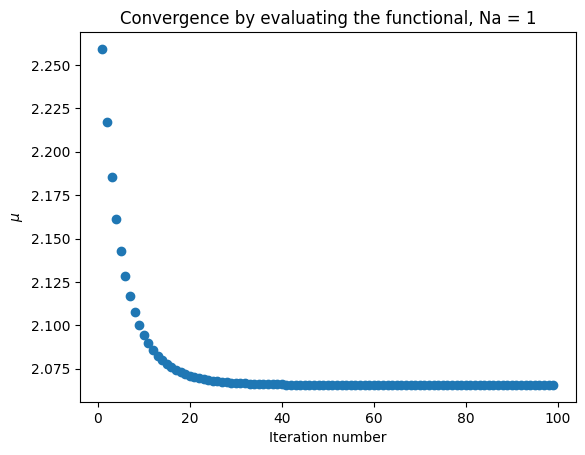

In [111]:
E_int2 = np.zeros(N)
E_ext2 = np.zeros(N)
E_kin2 = np.zeros(N)
mu_found2 = np.zeros(N)
dev_prime = np.zeros([M,N],float)
for m in range(N):
    for i in range(1,M-1):
        dev_prime[i][m] = (phi_mat_1[i][m] - phi_mat_1[i-1][m]) / (h) 
for m in range(N):
    for i in range(M):
        E_kin2[m] += 0.5 * dev_prime[i][m]**2 * h 
        E_ext2[m] += 0.5 * phi_mat_1[i][m]**2 *r[i]**2 * h 
        E_int2[m] += 0.5 * Na * phi_mat_1[i][m]**2 * rho_mat_1[i][m] *h 
        mu_found2[m] = (2*E_int2[m] + E_ext2[m] + E_kin2[m])

plt.scatter(range(1,N),mu_found2[1:])
plt.title("Convergence by evaluating the functional, Na = 1")
xlabel("Iteration number")
ylabel(r'$\mu$')

Text(0, 0.5, 'Difference')

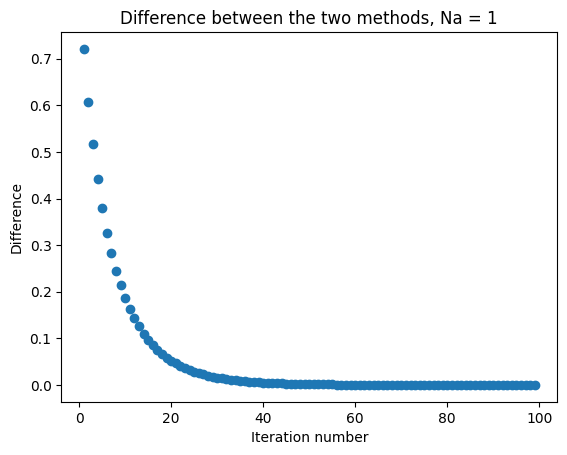

In [112]:
difference = mu_vec_1 - mu_found2
plt.scatter(range(1,N),abs(difference[1:]))
plt.title("Difference between the two methods, Na = 1")
xlabel("Iteration number")
ylabel("Difference")

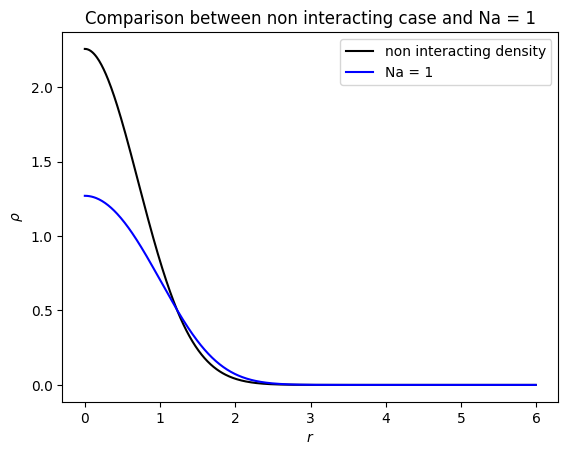

In [113]:
# comparison between the resulting density and the non interacting particle case

plt.plot(r,rho_non_interacting,color = 'k', label = 'non interacting density')
plt.plot(r[:],rho_mat_1[:,N-1],color = 'b', label = 'Na = 1')
pl.xlabel(r'$r$')
pl.ylabel(r'$\rho$')
pl.title("Comparison between non interacting case and Na = 1")
pl.legend(loc='upper right')

## Case Na = 10

In [114]:
Na = 10
alpha = 0.1
M = 600
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,8,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1.4
mu_2 = 5

v_mat_10 = np.zeros([M,N],float)
mu_vec_10 = np.zeros(N, float)
mu_vec_10[0] = mu_optimal
rho_mat_10 = np.zeros([M,N],float)
phi_mat_10 = np.zeros([M,N],float)

for m in range(1,N):
    v2 = (1-alpha) * v0 + (alpha) * v1    
    v_mat_10[:,m] = v2
    mu_vec_10[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2)
    rho_mat_10[:,m], phi_mat_10[:,m] = Numerov_rho_phi(mu_vec_10[m],v2)
    v0 = v2
    v1 = Na * rho_mat_10[:,m]
    print(m)

C:\Users\Hp\AppData\Local\Temp\ipykernel_11500\1962102331.py:61: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0, 0.5, '$\\mu$')

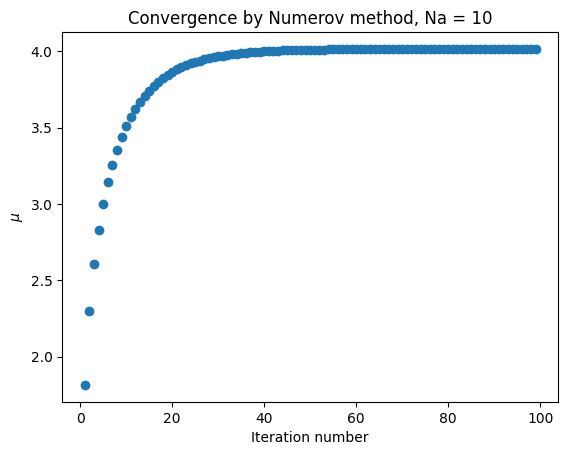

In [115]:
plt.scatter(range(1,N),mu_vec_10[1:])
plt.title("Convergence by Numerov method, Na = 10")
xlabel("Iteration number")
ylabel(r'$\mu$')

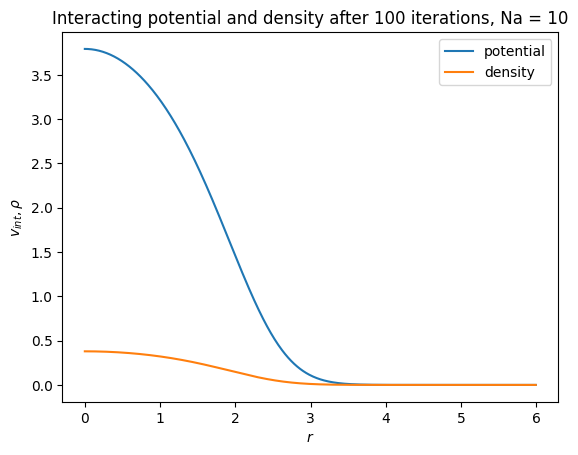

In [116]:
plt.plot(r,v_mat_10[:,N-1],label="potential")
plt.plot(r[:],rho_mat_10[:,N-1],label="density")
plt.title("Interacting potential and density after 100 iterations, Na = 10")
xlabel(r'$r$')
ylabel(r'$v_{int},\rho$')
plt.legend()

Text(0, 0.5, '$\\mu$')

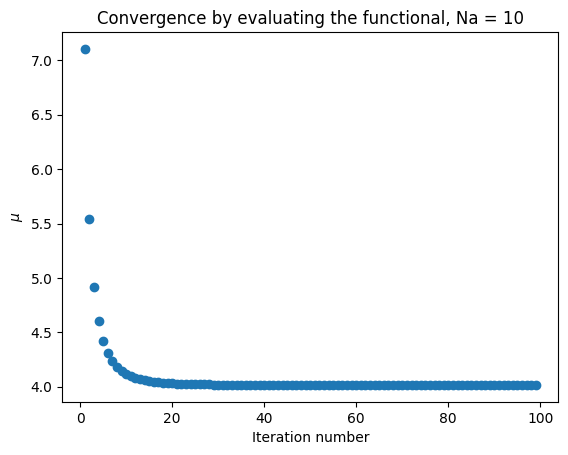

In [117]:
E_int2 = np.zeros(N)
E_ext2 = np.zeros(N)
E_kin2 = np.zeros(N)
mu_found2 = np.zeros(N)
dev_prime = np.zeros([M,N],float)
for m in range(N):
    for i in range(1,M-1):
        dev_prime[i][m] = (phi_mat_10[i][m] - phi_mat_10[i-1][m]) / (h) #(phi_mat[i+1][m]-2*phi_mat[i][m]+phi_mat[i-1][m])/h**2
for m in range(N):
    for i in range(M):
        E_kin2[m] += 0.5 * dev_prime[i][m]**2 * h #-0.5 * phi_mat[i][m] * dev_sec[i][m] * h * r[i]**2
        E_ext2[m] += 0.5 * phi_mat_10[i][m]**2 *r[i]**2 * h #0.5 * phi_mat[i][m]**2 *r[i]**4 * h 
        E_int2[m] += 0.5 * Na * phi_mat_10[i][m]**2 * rho_mat_10[i][m] *h #Na * phi_mat[i][m]**4 * h
        mu_found2[m] = (2*E_int2[m] + E_ext2[m] + E_kin2[m])

plt.scatter(range(1,N),mu_found2[1:])
plt.title("Convergence by evaluating the functional, Na = 10")
xlabel("Iteration number")
ylabel(r'$\mu$')

Text(0, 0.5, 'Difference')

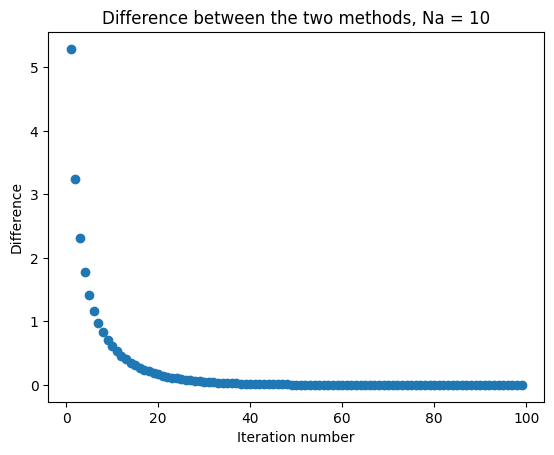

In [118]:
difference = mu_vec_10 - mu_found2
plt.scatter(range(1,N),abs(difference[1:]))
plt.title("Difference between the two methods, Na = 10")
xlabel("Iteration number")
ylabel("Difference")

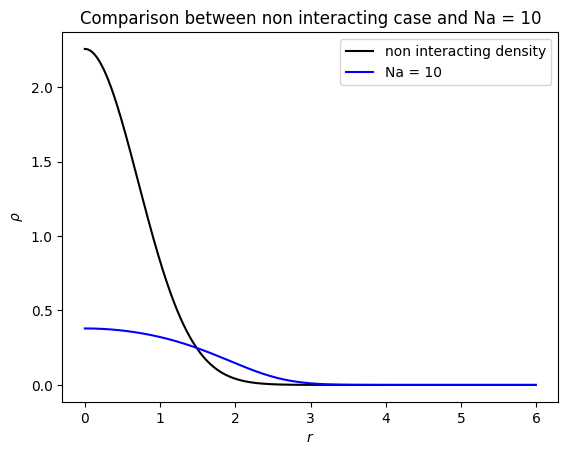

In [119]:
# comparison between the resulting density and the non interacting particle case

plt.plot(r,rho_non_interacting,color = 'k', label = 'non interacting density')
plt.plot(r[:],rho_mat_10[:,N-1],color = 'b', label = 'Na = 10')
pl.xlabel(r'$r$')
pl.ylabel(r'$\rho$')
pl.title("Comparison between non interacting case and Na = 10")
pl.legend(loc='upper right')

## Case Na = 100

In [120]:
Na = 100
alpha = 0.1
M = 500
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,2,8,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1.4
mu_2 = 10

v_mat_100 = np.zeros([M,N],float)
mu_vec_100 = np.zeros(N, float)
mu_vec_100[0] = mu_optimal
rho_mat_100 = np.zeros([M,N],float)
phi_mat_100 = np.zeros([M,N],float)

for m in range(1,N):
    v2 = (1-alpha) * v0 + (alpha) * v1    
    v_mat_100[:,m] = v2
    mu_vec_100[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2)
    rho_mat_100[:,m], phi_mat_100[:,m] = Numerov_rho_phi(mu_vec_100[m],v2)
    v0 = v2
    v1 = Na * rho_mat_100[:,m]
    print(m)

C:\Users\Hp\AppData\Local\Temp\ipykernel_11500\1962102331.py:61: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0, 0.5, '$\\mu$')

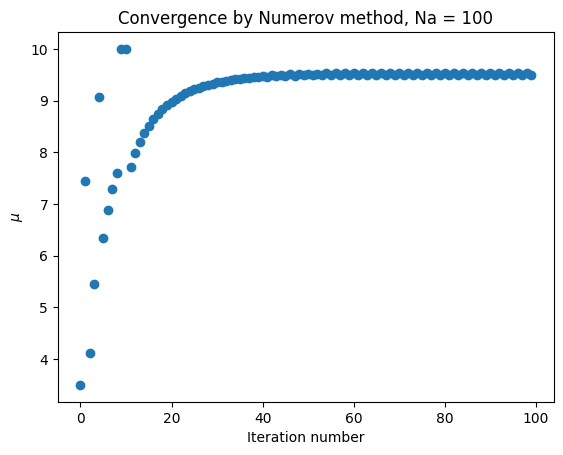

In [121]:
plt.scatter(range(N),mu_vec_100)
plt.title("Convergence by Numerov method, Na = 100")
xlabel("Iteration number")
ylabel(r'$\mu$')

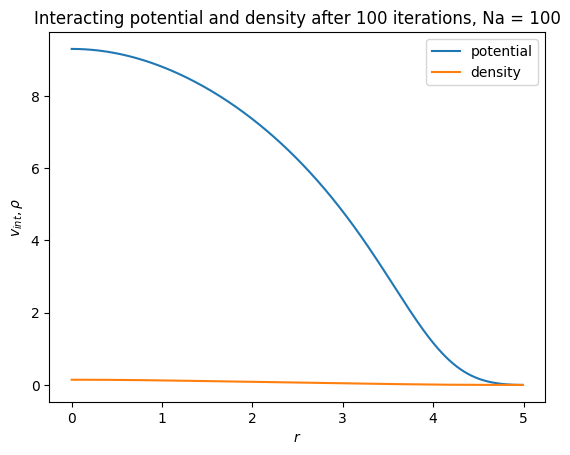

In [122]:
plt.plot(r,v_mat_100[:,N-1],label="potential")
plt.plot(r[:],rho_mat_100[:,N-1],label="density")
plt.title("Interacting potential and density after 100 iterations, Na = 100")
xlabel(r'$r$')
ylabel(r'$v_{int},\rho$')
plt.legend()

Text(0, 0.5, '$\\mu$')

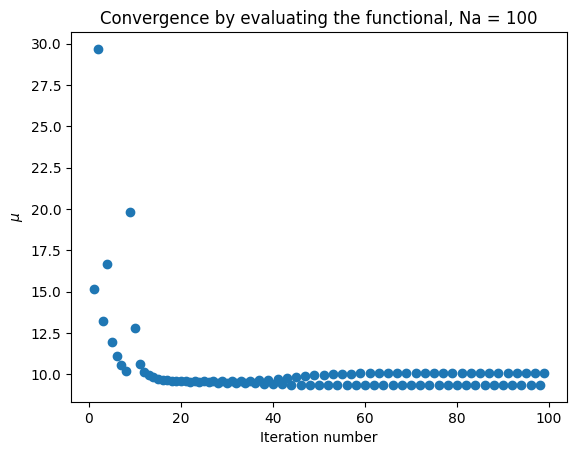

In [123]:
E_int2 = np.zeros(N)
E_ext2 = np.zeros(N)
E_kin2 = np.zeros(N)
mu_found2 = np.zeros(N)
dev_prime = np.zeros([M,N],float)
for m in range(N):
    for i in range(1,M-1):
        dev_prime[i][m] = (phi_mat_100[i][m] - phi_mat_100[i-1][m]) / (h) #(phi_mat[i+1][m]-2*phi_mat[i][m]+phi_mat[i-1][m])/h**2
for m in range(N):
    for i in range(M):
        E_kin2[m] += 0.5 * dev_prime[i][m]**2 * h #-0.5 * phi_mat[i][m] * dev_sec[i][m] * h * r[i]**2
        E_ext2[m] += 0.5 * phi_mat_100[i][m]**2 *r[i]**2 * h #0.5 * phi_mat[i][m]**2 *r[i]**4 * h 
        E_int2[m] += 0.5 * Na * phi_mat_100[i][m]**2 * rho_mat_100[i][m] *h #Na * phi_mat[i][m]**4 * h
        mu_found2[m] = (2*E_int2[m] + E_ext2[m] + E_kin2[m])

plt.scatter(range(1,N),mu_found2[1:])
plt.title("Convergence by evaluating the functional, Na = 100")
xlabel("Iteration number")
ylabel(r'$\mu$')

Text(0, 0.5, 'Difference')

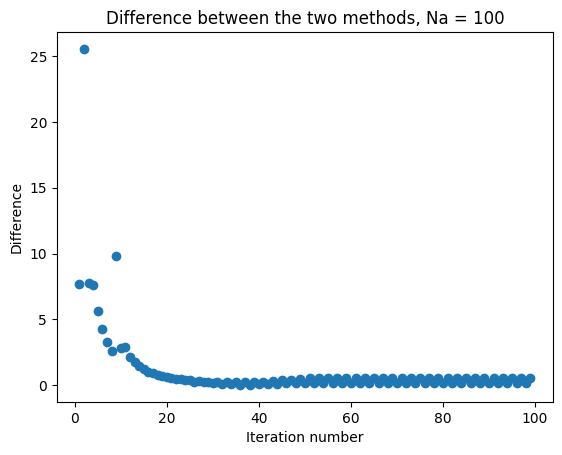

In [124]:
difference = mu_vec_100 - mu_found2
plt.scatter(range(1,N),abs(difference[1:]))
plt.title("Difference between the two methods, Na = 100")
xlabel("Iteration number")
ylabel("Difference")

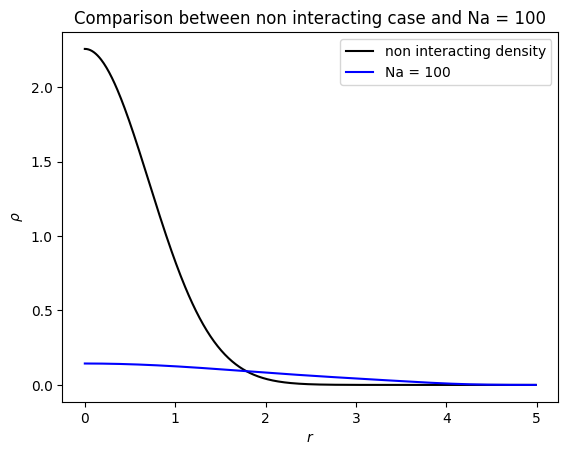

In [125]:
# comparison between the resulting density and the non interacting particle case

plt.plot(r[:500],rho_non_interacting[:500],color = 'k', label = 'non interacting density')
plt.plot(r[:500],rho_mat_100[:,N-1],color = 'b', label = 'Na = 100')
pl.xlabel(r'$r$')
pl.ylabel(r'$\rho$')
pl.title("Comparison between non interacting case and Na = 100")
pl.legend(loc='upper right')

We can easily see that convergence is guaranteed in all the cases from both methods, since the difference of the computed $\mu$, between the two procedures, iteration by iteration goes to zero as the number of iterations increases. In the following table we summarize the results obtained by the bisection method (up to the fifth significative figure for $\mu$).


| $Na$ | $\mu$ |
| --- | --- |
| 0.01 | 1.5079 |
|0.1|1.5759|
|1|2.0656|
|10|4.0161|
|100|9.5044|

# 5) Variety of the convergence speed

In this section, for Na = 0.01, 1, 10, we vary the mixing parameter $\alpha$ = 0.1, 0.3, 0.5, in order to see how the convergence speed changes. We observe that, as $\alpha$ increases, the number of iterations to reach a convergence of $\mu$ decreases. For Na=10 and $\alpha$=0.5 we did not manage to reach a convergence for $\mu$. For each case, we stop the iterations until a tolerance smaller than $10^{-6}$ between the $\mu$ computed in two subsequent iterations is reached.

## Case Na = 0.01 and $\alpha$ = 0.1

In [88]:
Na = 0.01
alpha = 0.1
M = 600
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,2,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1
mu_2 = 2

v_mat_001 = np.zeros([M,N],float)
mu_vec_001 = np.zeros(N, float)
mu_vec_001[0] = mu_optimal
rho_mat_001 = np.zeros([M,N],float)
phi_mat_001 = np.zeros([M,N],float)

for m in range(1,N):
    v2 = (1-alpha) * v0 + (alpha) * v1    
    v_mat_001[:,m] = v2
    mu_vec_001[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2)
    rho_mat_001[:,m], phi_mat_001[:,m] = Numerov_rho_phi(mu_vec_001[m],v2)
    v0 = v2
    v1 = Na * rho_mat_001[:,m]
    if(abs(mu_vec_001[m-1]-mu_vec_001[m])<1e-6):
        break

print('We get the value mu =',mu_vec_001[m],'after',m,'iterations.')

C:\Users\Hp\AppData\Local\Temp\ipykernel_22608\1182396435.py:62: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


We get the value mu = 1.507928261955385 after 65 iterations.


Text(0, 0.5, '$\\mu$')

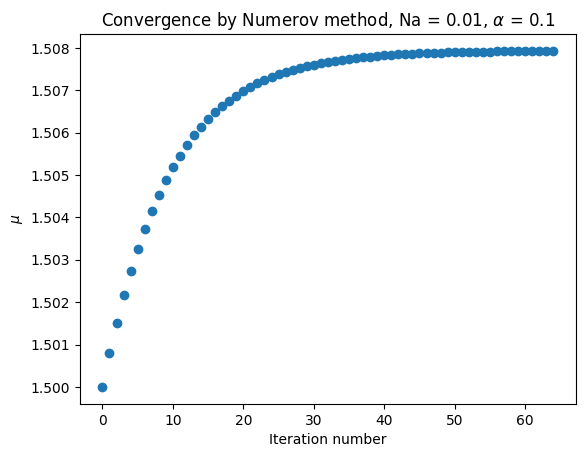

In [89]:
plt.scatter(range(0,m),mu_vec_001[:m])
plt.title("Convergence by Numerov method, Na = 0.01, " r'$\alpha$ = 0.1')
xlabel("Iteration number")
ylabel(r'$\mu$')

## Case Na = 1 and $\alpha$ = 0.1

In [90]:
Na = 1
alpha = 0.1
M = 600
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,2,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1.4
mu_2 = 2.5

v_mat_1 = np.zeros([M,N],float)
mu_vec_1 = np.zeros(N, float)
mu_vec_1[0] = mu_optimal
rho_mat_1 = np.zeros([M,N],float)
phi_mat_1 = np.zeros([M,N],float)

for m in range(1,N):
    v2 = (1-alpha) * v0 + (alpha) * v1    
    v_mat_1[:,m] = v2
    mu_vec_1[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2)
    rho_mat_1[:,m], phi_mat_1[:,m] = Numerov_rho_phi(mu_vec_1[m],v2)
    v0 = v2
    v1 = Na * rho_mat_1[:,m]
    if(abs(mu_vec_1[m-1]-mu_vec_1[m])<1e-6):
        break

print('We get the value mu =',mu_vec_1[m],'after',m,'iterations.')

C:\Users\Hp\AppData\Local\Temp\ipykernel_22608\1182396435.py:62: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


We get the value mu = 2.0656301668022934 after 98 iterations.


Text(0, 0.5, '$\\mu$')

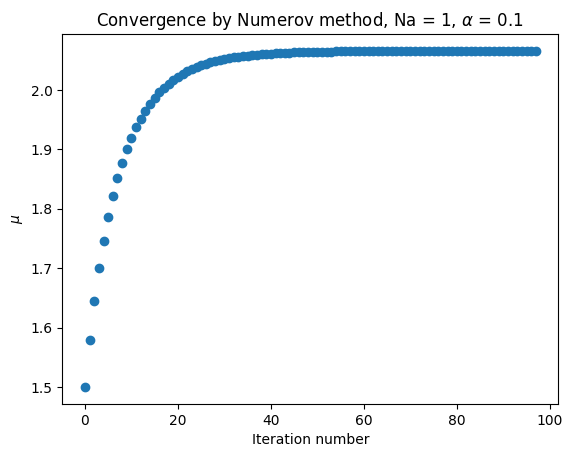

In [91]:
plt.scatter(range(0,m),mu_vec_1[:m])
plt.title("Convergence by Numerov method, Na = 1, " r'$\alpha$ = 0.1')
xlabel("Iteration number")
ylabel(r'$\mu$')

## Case Na = 10 and $\alpha$ = 0.1

In [92]:
Na = 10
alpha = 0.1
M = 600
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,4,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1.4
mu_2 = 5

v_mat_10 = np.zeros([M,N],float)
mu_vec_10 = np.zeros(N, float)
mu_vec_10[0] = mu_optimal
rho_mat_10 = np.zeros([M,N],float)
phi_mat_10 = np.zeros([M,N],float)

for m in range(1,N):
    v2 = (1-alpha) * v0 + (alpha) * v1    
    v_mat_10[:,m] = v2
    mu_vec_10[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2)
    rho_mat_10[:,m], phi_mat_10[:,m] = Numerov_rho_phi(mu_vec_10[m],v2)
    v0 = v2
    v1 = Na * rho_mat_10[:,m]
    if(abs(mu_vec_10[m-1]-mu_vec_10[m])<1e-6):
        break

print('We get the value mu =',mu_vec_10[m],'after',m,'iterations.')

C:\Users\Hp\AppData\Local\Temp\ipykernel_22608\1182396435.py:62: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


We get the value mu = 4.016085272619966 after 99 iterations.


Text(0, 0.5, '$\\mu$')

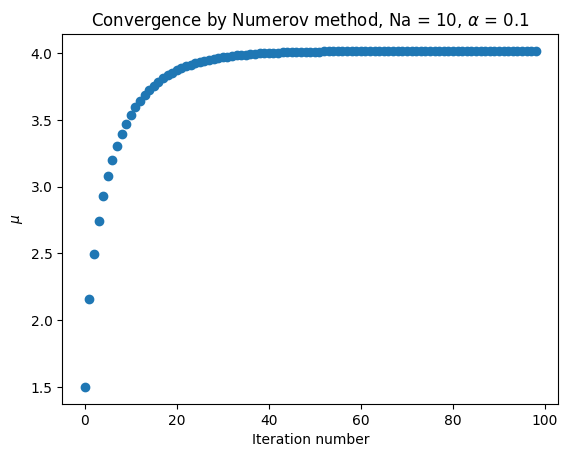

In [93]:
plt.scatter(range(0,m),mu_vec_10[:m])
plt.title("Convergence by Numerov method, Na = 10, " r'$\alpha$ = 0.1')
xlabel("Iteration number")
ylabel(r'$\mu$')

## Case Na = 0.01 and $\alpha$ = 0.3

In [94]:
Na = 0.01
alpha = 0.3
M = 600
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,2,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1
mu_2 = 2

v_mat_001 = np.zeros([M,N],float)
mu_vec_001 = np.zeros(N, float)
mu_vec_001[0] = mu_optimal
rho_mat_001 = np.zeros([M,N],float)
phi_mat_001 = np.zeros([M,N],float)

for m in range(1,N):
    v2 = (1-alpha) * v0 + (alpha) * v1    
    v_mat_001[:,m] = v2
    mu_vec_001[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2)
    rho_mat_001[:,m], phi_mat_001[:,m] = Numerov_rho_phi(mu_vec_001[m],v2)
    v0 = v2
    v1 = Na * rho_mat_001[:,m]
    if(abs(mu_vec_001[m-1]-mu_vec_001[m])<1e-6):
        break

print('We get the value mu =',mu_vec_001[m],'after',m,'iterations.')

C:\Users\Hp\AppData\Local\Temp\ipykernel_22608\1182396435.py:62: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


We get the value mu = 1.5079343634988618 after 23 iterations.


Text(0, 0.5, '$\\mu$')

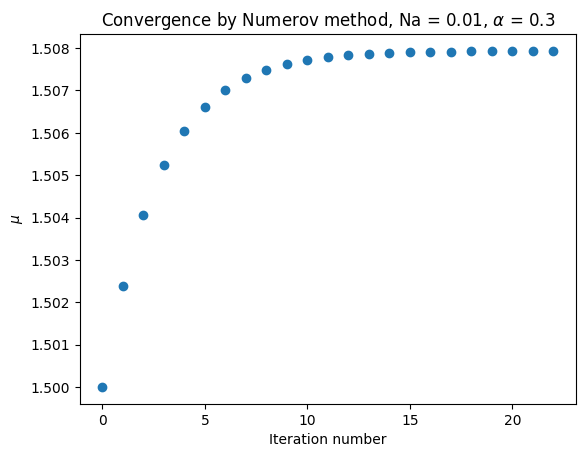

In [95]:
plt.scatter(range(0,m),mu_vec_001[:m])
plt.title("Convergence by Numerov method, Na = 0.01, " r'$\alpha$ = 0.3')
xlabel("Iteration number")
ylabel(r'$\mu$')

## Case Na = 1 and $\alpha$ = 0.3

In [96]:
Na = 1
alpha = 0.3
M = 600
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,2,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1.4
mu_2 = 2.5

v_mat_1 = np.zeros([M,N],float)
mu_vec_1 = np.zeros(N, float)
mu_vec_1[0] = mu_optimal
rho_mat_1 = np.zeros([M,N],float)
phi_mat_1 = np.zeros([M,N],float)

for m in range(1,N):
    v2 = (1-alpha) * v0 + (alpha) * v1    
    v_mat_1[:,m] = v2
    mu_vec_1[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2)
    rho_mat_1[:,m], phi_mat_1[:,m] = Numerov_rho_phi(mu_vec_1[m],v2)
    v0 = v2
    v1 = Na * rho_mat_1[:,m]
    if(abs(mu_vec_1[m-1]-mu_vec_1[m])<1e-6):
        break

print('We get the value mu =',mu_vec_1[m],'after',m,'iterations.')

C:\Users\Hp\AppData\Local\Temp\ipykernel_22608\1182396435.py:62: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


We get the value mu = 2.065636411162632 after 33 iterations.


Text(0, 0.5, '$\\mu$')

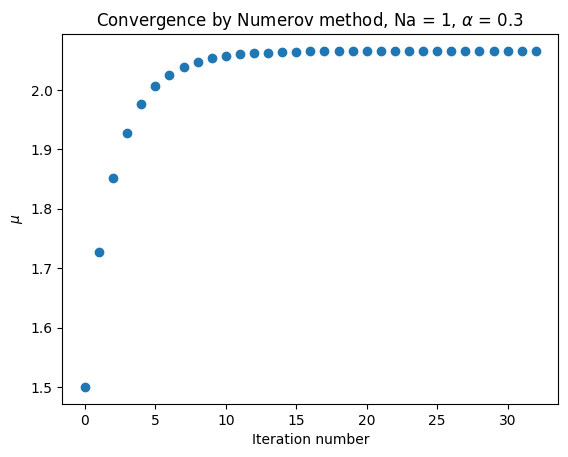

In [97]:
plt.scatter(range(0,m),mu_vec_1[:m])
plt.title("Convergence by Numerov method, Na = 1, " r'$\alpha$ = 0.3')
xlabel("Iteration number")
ylabel(r'$\mu$')

## Case Na = 10 and $\alpha$ = 0.3

In [98]:
Na = 10
alpha = 0.3
M = 600
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,2,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1.4
mu_2 = 5

v_mat_10 = np.zeros([M,N],float)
mu_vec_10 = np.zeros(N, float)
mu_vec_10[0] = mu_optimal
rho_mat_10 = np.zeros([M,N],float)
phi_mat_10 = np.zeros([M,N],float)

for m in range(1,N):
    v2 = (1-alpha) * v0 + (alpha) * v1    
    v_mat_10[:,m] = v2
    mu_vec_10[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2)
    rho_mat_10[:,m], phi_mat_10[:,m] = Numerov_rho_phi(mu_vec_10[m],v2)
    v0 = v2
    v1 = Na * rho_mat_10[:,m]
    if(abs(mu_vec_10[m-1]-mu_vec_10[m])<1e-6):
        break

print('We get the value mu =',mu_vec_10[m],'after',m,'iterations.')

C:\Users\Hp\AppData\Local\Temp\ipykernel_22608\1182396435.py:62: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


We get the value mu = 4.016109668253922 after 36 iterations.


Text(0, 0.5, '$\\mu$')

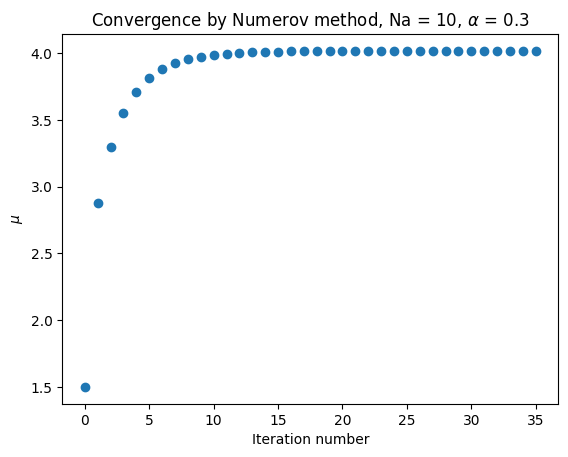

In [99]:
plt.scatter(range(0,m),mu_vec_10[:m])
plt.title("Convergence by Numerov method, Na = 10, " r'$\alpha$ = 0.3')
xlabel("Iteration number")
ylabel(r'$\mu$')

## Case Na = 0.01 and $\alpha$ = 0.5

In [100]:
Na = 0.01
alpha = 0.5
M = 600
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,2,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1
mu_2 = 2

v_mat_001 = np.zeros([M,N],float)
mu_vec_001 = np.zeros(N, float)
mu_vec_001[0] = mu_optimal
rho_mat_001 = np.zeros([M,N],float)
phi_mat_001 = np.zeros([M,N],float)

for m in range(1,N):
    v2 = (1-alpha) * v0 + (alpha) * v1    
    v_mat_001[:,m] = v2
    mu_vec_001[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2)
    rho_mat_001[:,m], phi_mat_001[:,m] = Numerov_rho_phi(mu_vec_001[m],v2)
    v0 = v2
    v1 = Na * rho_mat_001[:,m]
    if(abs(mu_vec_001[m-1]-mu_vec_001[m])<1e-6):
        break

print('We get the value mu =',mu_vec_001[m],'after',m,'iterations.')

C:\Users\Hp\AppData\Local\Temp\ipykernel_22608\1182396435.py:62: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


We get the value mu = 1.5079355340621987 after 13 iterations.


Text(0, 0.5, '$\\mu$')

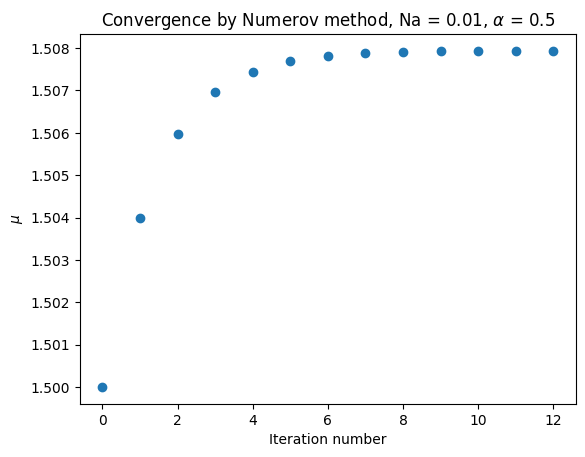

In [101]:
plt.scatter(range(0,m),mu_vec_001[:m])
plt.title("Convergence by Numerov method, Na = 0.01, " r'$\alpha$ = 0.5')
xlabel("Iteration number")
ylabel(r'$\mu$')

## Case Na = 1 and $\alpha$ = 0.5

In [102]:
Na = 1
alpha = 0.5
M = 600
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,2,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1.4
mu_2 = 2.5

v_mat_1 = np.zeros([M,N],float)
mu_vec_1 = np.zeros(N, float)
mu_vec_1[0] = mu_optimal
rho_mat_1 = np.zeros([M,N],float)
phi_mat_1 = np.zeros([M,N],float)

for m in range(1,N):
    v2 = (1-alpha) * v0 + (alpha) * v1    
    v_mat_1[:,m] = v2
    mu_vec_1[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2)
    rho_mat_1[:,m], phi_mat_1[:,m] = Numerov_rho_phi(mu_vec_1[m],v2)
    v0 = v2
    v1 = Na * rho_mat_1[:,m]
    if(abs(mu_vec_1[m-1]-mu_vec_1[m])<1e-6):
        break

print('We get the value mu =',mu_vec_1[m],'after',m,'iterations.')

C:\Users\Hp\AppData\Local\Temp\ipykernel_22608\1182396435.py:62: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


We get the value mu = 2.065637362749113 after 18 iterations.


Text(0, 0.5, '$\\mu$')

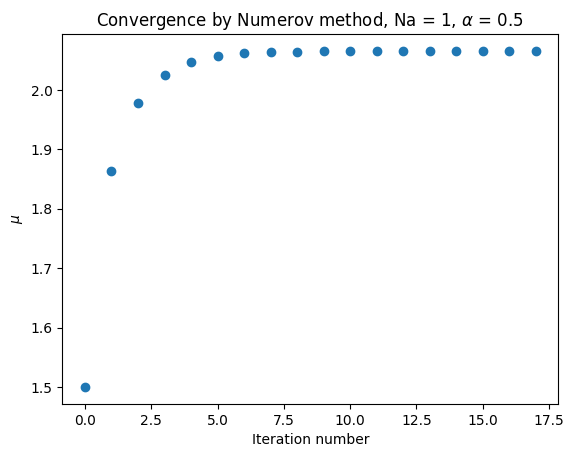

In [103]:
plt.scatter(range(0,m),mu_vec_1[:m])
plt.title("Convergence by Numerov method, Na = 1, " r'$\alpha$ = 0.5')
xlabel("Iteration number")
ylabel(r'$\mu$')

## Case Na = 10 and $\alpha$ = 0.5

In [104]:
Na = 10
alpha = 0.5
M = 600
N = 100
h = 0.01

v0 = np.zeros(M, float)
mu_optimal = bisection_phi(Numerov_last_value,1,2,v0)
rho, phi = Numerov_rho_phi(mu_optimal,v0)
v1 = Na * rho

r = np.zeros(M, float)
for i in range(M):
    r[i] = h*i

mu_1 = 1.4
mu_2 = 2.5

v_mat_10 = np.zeros([M,N],float)
mu_vec_10 = np.zeros(N, float)
mu_vec_10[0] = mu_optimal
rho_mat_10 = np.zeros([M,N],float)
phi_mat_10 = np.zeros([M,N],float)

for m in range(1,N):
    v2 = (1-alpha) * v0 + (alpha) * v1    
    v_mat_10[:,m] = v2
    mu_vec_10[m] = bisection_phi(Numerov_last_value,mu_1,mu_2,v2)
    rho_mat_10[:,m], phi_mat_10[:,m] = Numerov_rho_phi(mu_vec_10[m],v2)
    v0 = v2
    v1 = Na * rho_mat_10[:,m]
    if(abs(mu_vec_10[m-1]-mu_vec_10[m])<1e-6):
        break

print('We get the value mu =',mu_vec_10[m],'after',m,'iterations.')

C:\Users\Hp\AppData\Local\Temp\ipykernel_22608\1182396435.py:62: RuntimeWarning: invalid value encountered in divide
  rho = phi**2/r**2


We get the value mu = 2.499991607666016 after 2 iterations.


Text(0, 0.5, '$\\mu$')

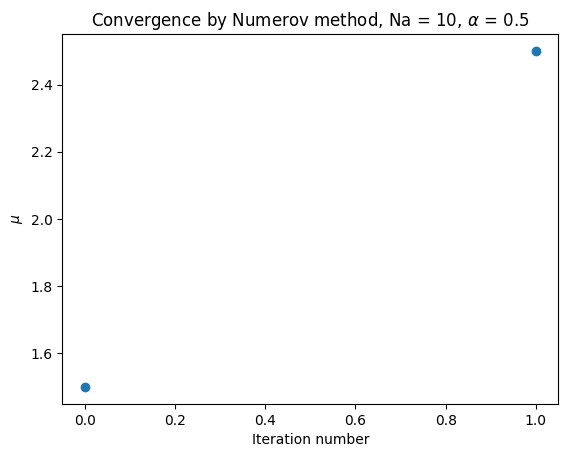

In [105]:
plt.scatter(range(0,m),mu_vec_10[:m])
plt.title("Convergence by Numerov method, Na = 10, " r'$\alpha$ = 0.5')
xlabel("Iteration number")
ylabel(r'$\mu$')

Here we summarize our results, where the values of $\mu$ are reported up to the fifth significant figure.

| $Na$ | $\alpha$ | Iterations |$\mu$|
| --- | --- | --- | --- |
|0.01  | 0.1 |65  | 1.5079 |
| 1 | 0.1 | 98 | 2.0656 |
| 10 |0.1  | 99 | 4.0161 |
|0.01  | 0.3 | 23 | 1.5079 |
| 1 | 0.3 | 33 | 2.0656 |
| 10 | 0.3 | 36 |4.0161  |
| 0.01 | 0.5 | 13 |1.5079  |
| 1 | 0.5 | 18 | 2.0656 |
| 10 | 0.5 | 2 | 2.5000 |

# 6) Solution of GP equation via variational method

In this section we solve the GP equation by expanding the solution on a basis of 15 harmonic oscillator wavefunctions: 
$$
u_{n}(r) = \tilde N_n(\nu) e^{-\frac{r^{2}}{2}} H_{2n+1}(r)
$$
where $\tilde N_n(\nu)$ is the factor which guarantees the wavefunctions to be normalized to 1 ($\nu$ is henceforth set equal to 1/2):
$$
|\tilde N_n(\nu)|^{2} = \sqrt{\frac{2\nu}{\pi}} \frac{1}{4^{n}(2n+1)!}
$$.
In order to do that, we have to compute the Hamiltonian of the system:
$$
H = E_{Kin} + E_{Ext} + E_{Int}
$$
and diagonalize $\mu_{matrix}= H + E_{Int}$ to find the first eigenvector, that we use to compute the density $\rho$, and the first eigevalue, corresponding to $\mu$. Therefore, we evaluete the kinetic energy as following:
$$
E_{kin} = -\frac{1}{2}\int_{0}^{\infty} dr u_{n}(r)\nabla^{2}u_{m}(r) = \frac{1}{2}\int_{0}^{\infty} dr \nabla u_{n}(r)\nabla u_{m}(r) 
$$
where in the last step an integration by parts is performed (the gradient simply the derivative with respect to the radial coordinate).
For the external potential:
$$
E_{ext} = \frac{1}{2}\int_{0}^{\infty} dr u_{n}(r)r^{2}u_{m}(r) 
$$
and for the interaction potential:
$$
E_{int} = \frac{1}{2}\int_{0}^{\infty} dr u_{n}(r)v_{int}(r)u_{m}(r)
$$
where $v_{int}(r)=Na \rho(r)$ and $\rho(r) = \frac{u(r)^{2}}{r^{2}}$, computed with the first eigenvector $u(r)$ at the previous iteration.
We iterate evaluating each time $E_{int}$ until we reach a convergence, defined by the condition that $\mu_{i}-\mu_{i-1} <$ tolerance (i is an index referring to the iteration). We choose a tolerance of $10^{-5}$ for $Na = 0.01$, $10^{-4}$ for $Na = 0.1, 1, 10$ and $10^{-3}$ for $Na = 100$.
We find results consistent with those obtained through the previous method, as we can see in the table at the end of this section.

In [2]:
def He(x,n):  # Polinomi di Hermite
    h0=1
    if(n==0):
        return h0
    h1=2*x
    if(n==1):
        return h1
    if(n>1):
        for i in range(2,n+1):
            h2=2*x*h1-2*(i-1)*h0
            h0=h1
            h1=h2
        return h2
    
def dHe(x,n):  # Derivata prima dei polinomi di Hermite secondo la formula iterativa
    if(n==0):
        return 0
    else:
        H_prime = 2*n*He(x,n-1)
        return H_prime

In [3]:
nu = 1/2

def Norm(n):  # Fattore di normalizzazione per le funzioni d'onda radiali
    N_quadro = np.sqrt(2*nu/sp.pi) / (4**n * math.factorial(2*n+1))
    N = np.sqrt(N_quadro)
    return N 

def u(x,n):  # Funzioni d'onda radiali
    y = np.sqrt(2*nu) * x
    u = Norm(n) * np.exp(- nu * x**2) * He(y,2*n+1)
    return u

In [4]:
S = 15 # numero di funzioni d'onda

def du(x,n):  # derivata delle funzioni d'onda radiali
    risultato = Norm(n) * np.exp(- nu * x**2) * (-2*nu*x*He(np.sqrt(2*nu)*x,2*n+1) + dHe(np.sqrt(2*nu)*x,2*n+1)*np.sqrt(2*nu))
    return risultato

def element_kin1(m,n):  # elemento di matrice dell'energia cinetica
    ris, err = quad(lambda x: du(x,n) * du(x,m), 0, np.inf)
    risultato = 0.5 * ris
    return risultato

def element_ext(m,n):  # elemento di matrice del potenziale armonico esterno
    ris, err = quad(lambda x: u(x,m) * x**2 * u(x,n), 0, np.inf)
    risultato = 0.5 * ris
    return risultato

In [5]:
def u_vettore(x):  # vettore che contiene le funzioni d'onda per tutti i valori del numero quantico n = 0,...,14
    u_vec = np.zeros(S)
    for i in range(S):
        u_vec[i] = u(x,i)
    return u_vec  

def v1_var(x,autovettore):  # potenziale di interazione
    v1 = Na * (np.dot(autovettore[:,0],u_vettore(x)))**2/(x**2)
    return v1

def element_int1(m,n,v1_var,autovettore):  # elemento di matrice del potenziale di interazione
    ris, err = quad(lambda x: u(x, m) * v1_var(x,autovettore) * u(x, n), 0, np.inf)
    risultato = 0.5  * ris
    return risultato

In [6]:
H_kin_ext = np.zeros([S,S],float)  # matrice che contiene la parte cinetica e il potenziale armonico dell'Hamiltoniana complessiva
for m in range(S):
    for n in range(S):
            H_kin_ext[m,n] += element_kin1(m,n) + element_ext(m,n)

In [7]:
# Costruisco l'Hamiltoniana del sistema non interagente, diagonalizzo e verifico che lo stato fondamentale corrisponde 
# all'autovalore più basso dell'oscillatore armonico

H0 = np.zeros([S,S],float)
for m in range(S):
    for n in range(S):
        H0[m,n] += element_kin1(m,n) + element_ext(m,n)
H0_autovalori, H0_autovettori = eigh(H0)
mu_var_H0 = H0_autovalori[0]
print('The eigenvalue of the harmonic oscillator ground state is', mu_var_H0)

The eigenvalue of the harmonic oscillator ground state is 1.4999999999999998


## Case Na = 1

In [15]:
# Prima iterazione

Na = 1
H1 = np.zeros([S,S],float) # matrice Hamiltoniana
alpha = 0.1
H_int1 = np.zeros([S,S],float) # matrice del potenziale interno

for m in range(S): # riempio la matrice del potenziale interno
    for n in range(S):
        H_int1[m,n] +=  alpha * element_int1(m,n,v1_var,H0_autovettori)
    print(m)

H1 = H_kin_ext + 2*H_int1 # riempio l'Hamiltoniana

H1_autovalori, H1_autovettori = eigh(H1)  # Diagonalizzo l'Hamiltoniana
mu_var_H1 = H1_autovalori[0] # salvo l'autovalore più basso dopo la prima iterazione
print('After the first iteration we get mu =', mu_var_H1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
After the first iteration we get mu = 1.5783618816615015


In [16]:
N = 50
H = np.zeros([S,S],float)
H_int = np.zeros([S,S],float)
mu_var_H_1 = np.zeros(N,float) # vettore dei valori di mu per ogni iterazione
mu_var_H_1[0] = mu_var_H0 # al primo posto metto l'autovalore dell'oscillatore armonico
mu_var_H_1[1] = mu_var_H1 # al secondo posto metto l'autovalore ottenuto dopo la prima iterazione
H_autovettori = H1_autovettori # alla seconda iterazione, il potenziale v1 = v_new lo costruisco con l'Hamiltoniana vecchia 

for i in range(2,N):
    for m in range(S):
        for n in range(S):
            H_int[m,n] = (1-alpha) * H_int1[m,n] + alpha * element_int1(m,n,v1_var,H_autovettori) # formula di mixing per il potenziale, all'inizio v0 = v_old è il potenziale ottenuto alla seconda iterazione
        print(m)
    H = H_kin_ext + 2*H_int
    H_autovalori, H_autovettori = eigh(H) # diagonalizzo l'Hamiltoniana complessiva
    
    mu_var_H_1[i] = H_autovalori[0] # salvo l'autovalore 
    print(mu_var_H_1[i])
    H_int1 = H_int # aggiorno il potenziale: come nel caso delle iterazioni con Numerov, questa riga corrisponde a porre v0 = v2
    if(abs((mu_var_H_1[i]-mu_var_H_1[i-1]) < 10e-4)): # termino le iterazioni imponendo questa tolleranza su due valori di mu consecutivi
        break

print('After',i,'iterations we get mu =',mu_var_H_1[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.6439669669324457
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.6993664429564985
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.7464839149682927
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.7867978604092682
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.821464289551855
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.8514009676349599
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.877346410180746
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.899901992310628
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.9195625420609956
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.9367389403255242
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.9517750794688462
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.9649607774461373
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.97654174865187
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.9867274022124795
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.995697014692881
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
2.0036046705731536
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
2.0105832569883244
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
2.01674772395618
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
2

Text(0, 0.5, '\\mu')

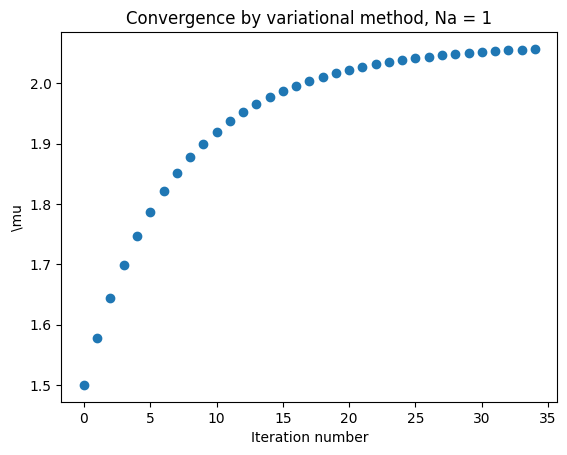

In [ ]:
# Plotto mu in funzione delle iterazioni

plt.scatter(range(35),mu_var_H_1[:35])
plt.title('Convergence by variational method, Na = 1')
xlabel('Iteration number')
ylabel(r'\mu')

## Case Na = 0.01

In [115]:
# Prima iterazione

Na = 0.01
H1 = np.zeros([S,S],float)
alpha = 0.1
H_int1 = np.zeros([S,S],float)

for m in range(S):
    for n in range(S):
        H_int1[m,n] =  alpha * element_int1(m,n,v1_var,H0_autovettori)
    print(m)

H1 = H_kin_ext + 2*H_int1

H1_autovalori, H1_autovettori = eigh(H1)
mu_var_H1_001 = H1_autovalori[0]
print('After the first iteration we get mu =',mu_var_H1_001)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
After the first iteration we get mu = 1.500797741933605


In [116]:
N = 50
H = np.zeros([S,S],float)
H_int = np.zeros([S,S],float)
mu_var_H_001 = np.zeros(N,float)
mu_var_H_001[0] = mu_var_H0
mu_var_H_001[1] = mu_var_H1_001
H_autovettori = H1_autovettori

for i in range(2,N):
    for m in range(S):
        for n in range(S):
            H_int[m,n] = (1-alpha) * H_int1[m,n] + alpha * element_int1(m,n,v1_var,H_autovettori)
        print(m)
    H = H_kin_ext + 2*H_int
    H_autovalori, H_autovettori = eigh(H)
    
    mu_var_H_001[i] = H_autovalori[0]
    print(mu_var_H_001[i])
    H_int1 = H_int
    if(abs((mu_var_H_001[i]-mu_var_H_001[i-1]) < 10e-5)):
        break

print('After',i,'iterations we get mu =',mu_var_H_001[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5015151809117098
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5021604227163114
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5027407506960972
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5032627100171314
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5037321831307413
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5041544574026648
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5045342857407793
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.504875940965064
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5051832645809176
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5054597105443426
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5057083845432286
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5059320792623272
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.506133306049095
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.506314323353141
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5064771622723048
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5066236495032588
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5067554279631719
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5068739753210847
0
1
2
3
4
5
6
7
8
9
10
11
12
13

Text(0, 0.5, '$\\mu$')

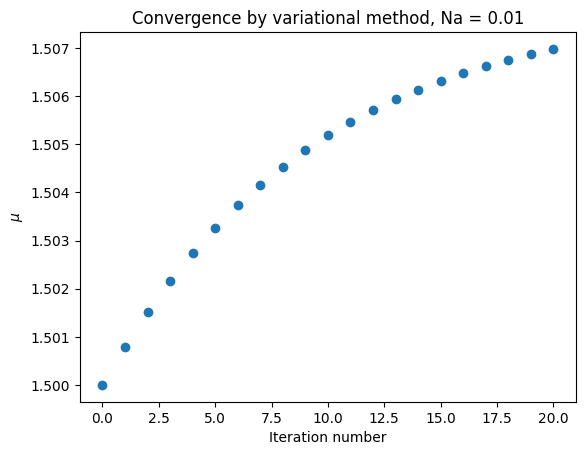

In [117]:
plt.scatter(range(i),mu_var_H_001[:i])
plt.title('Convergence by variational method, Na = 0.01')
xlabel('Iteration number')
ylabel(r'$\mu$')

## Case Na = 0.1

In [118]:
# Prima iterazione

Na = 0.1
H1 = np.zeros([S,S],float)
alpha = 0.1
H_int1 = np.zeros([S,S],float)

for m in range(S):
    for n in range(S):
        H_int1[m,n] =  alpha * element_int1(m,n,v1_var,H0_autovettori)
    print(m)

H1 = H_kin_ext + 2*H_int1

H1_autovalori, H1_autovettori = eigh(H1)
mu_var_H1_01 = H1_autovalori[0]
print('After the first iteration we get mu =',mu_var_H1_01)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
After the first iteration we get mu = 1.507964582203349


In [119]:
N = 50
H = np.zeros([S,S],float)
H_int = np.zeros([S,S],float)
mu_var_H_01 = np.zeros(N,float)
mu_var_H_01[0] = mu_var_H0
mu_var_H_01[1] = mu_var_H1_01
H_autovettori = H1_autovettori

for i in range(2,N):
    for m in range(S):
        for n in range(S):
            H_int[m,n] = (1-alpha) * H_int1[m,n] + alpha * element_int1(m,n,v1_var,H_autovettori)
        print(m)
    H = H_kin_ext + 2*H_int
    H_autovalori, H_autovettori = eigh(H)
    
    mu_var_H_01[i] = H_autovalori[0]
    print(mu_var_H_01[i])
    H_int1 = H_int
    if(abs((mu_var_H_01[i]-mu_var_H_01[i-1]) < 10e-4)):
        break

print('After',i,'iterations we get mu =',mu_var_H_01[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5150801725658807
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5214397693344464
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5271256998908667
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5322109373369717
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5367602377458458
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5408311254007496
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5444747487305623
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.547736625878795
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5506572957516493
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5532728878499706
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5556156220960577
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5577142481354702
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5595944321586845
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5612790980932734
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.5627887290203488
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.564141633833908
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.565354183459596
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.566441020357164
0
1
2
3
4
5
6
7
8
9
10
11
12
13


Text(0, 0.5, '$\\mu$')

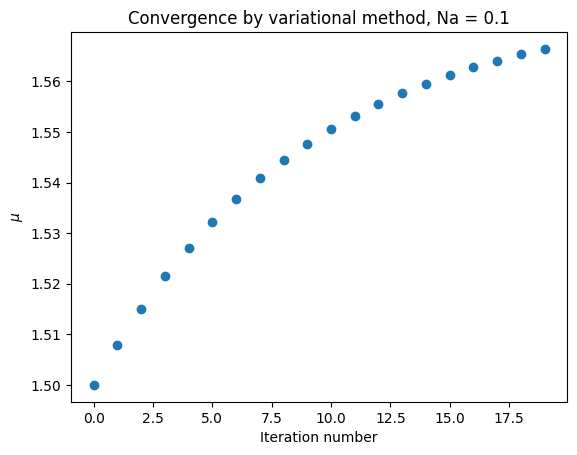

In [120]:
plt.scatter(range(i),mu_var_H_01[:i])
plt.title('Convergence by variational method, Na = 0.1')
xlabel('Iteration number')
ylabel(r'$\mu$')

## Case Na = 10

In [31]:
# Prima iterazione

Na = 10
H1 = np.zeros([S,S],float)
alpha = 0.1
H_int1 = np.zeros([S,S],float)

for m in range(S):
    for n in range(S):
        H_int1[m,n] =  alpha * element_int1(m,n,v1_var,H0_autovettori)
    print(m)

H1 = H_kin_ext + 2*H_int1

H1_autovalori, H1_autovettori = eigh(H1)
mu_var_H1_10 = H1_autovalori[0]
print('After the first iteration we get mu =',mu_var_H1_10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
After the first iteration we get mu = 2.1594663202479865


In [32]:
N = 50
H = np.zeros([S,S],float)
H_int = np.zeros([S,S],float)
mu_var_H_10 = np.zeros(N,float)
mu_var_H_10[0] = mu_var_H0
mu_var_H_10[1] = mu_var_H1_10
H_autovettori = H1_autovettori

for i in range(2,N):
    for m in range(S):
        for n in range(S):
            H_int[m,n] = (1-alpha) * H_int1[m,n] + alpha * element_int1(m,n,v1_var,H_autovettori)
        print(m)
    H = H_kin_ext + 2*H_int
    H_autovalori, H_autovettori = eigh(H)
    
    mu_var_H_10[i] = H_autovalori[0]
    print(mu_var_H_10[i])
    H_int1 = H_int
    if(abs((mu_var_H_10[i]-mu_var_H_10[i-1]) < 10e-4)):
        break

print('After',i,'iterations we get mu =',mu_var_H_10[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
2.4985548830957374
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
2.7406194412293745
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
2.927836381699187
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.0785401227665425
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.2028213725679704
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.3069957482152645
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.3953504850233207
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.4709602954683447
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.536117929311559
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.5925833079924203
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.641738350418205
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.6846885416891624
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.7223322549315228
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.755409448912932
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.7845366488031473
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.81023256044823
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.8329371697668426
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3.853026241814778
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0, 0.5, '$\\mu$')

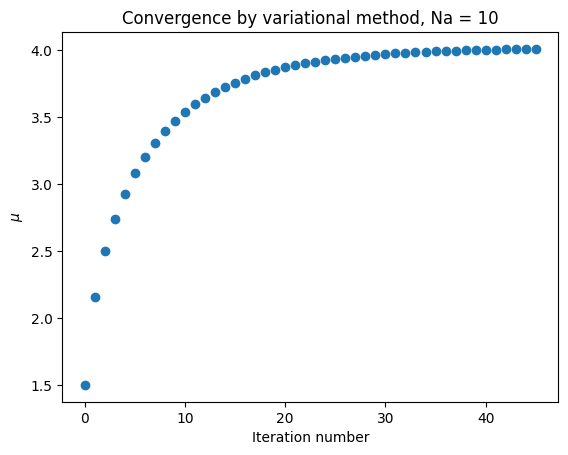

In [33]:
plt.scatter(range(i),mu_var_H_10[:i])
plt.title('Convergence by variational method, Na = 10')
xlabel('Iteration number')
ylabel(r'$\mu$')

## Case Na = 100

In [34]:
# Prima iterazione

Na = 100
H1 = np.zeros([S,S],float)
alpha = 0.1
H_int1 = np.zeros([S,S],float)

for m in range(S):
    for n in range(S):
        H_int1[m,n] =  alpha * element_int1(m,n,v1_var,H0_autovettori)
    print(m)

H1 = H_kin_ext + 2*H_int1

H1_autovalori, H1_autovettori = eigh(H1)
mu_var_H1_100 = H1_autovalori[0]
print('After the first iteration we get mu =',mu_var_H1_100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
After the first iteration we get mu = 3.717164500180976


In [35]:
N = 50
H = np.zeros([S,S],float)
H_int = np.zeros([S,S],float)
mu_var_H_100 = np.zeros(N,float)
mu_var_H_100[0] = mu_var_H0
mu_var_H_100[1] = mu_var_H1_100
H_autovettori = H1_autovettori

for i in range(2,N):
    for m in range(S):
        for n in range(S):
            H_int[m,n] = (1-alpha) * H_int1[m,n] + alpha * element_int1(m,n,v1_var,H_autovettori)
        print(m)
    H = H_kin_ext + 2*H_int
    H_autovalori, H_autovettori = eigh(H)
    
    mu_var_H_100[i] = H_autovalori[0]
    print(mu_var_H_100[i])
    H_int1 = H_int
    if(abs((mu_var_H_100[i]-mu_var_H_100[i-1]) < 10e-3)):
        break

print('After',i,'iterations we get mu =',mu_var_H_100[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
5.005247629862395
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
5.805832352756149
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
6.380432099740587
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
6.82460446297662
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
7.182588327669834
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
7.477584237845824
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
7.72552547146886
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
7.936339219915091
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
8.117735374876304
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
8.274685043857973
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
8.41167511071326
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
8.531344611173415
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
8.636719971455621
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
8.729190063758656
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
8.811144418625476
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
8.883179803514677
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
8.947426730407862
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
9.003855174338973
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
9.054553974105

Text(0, 0.5, '$\\mu$')

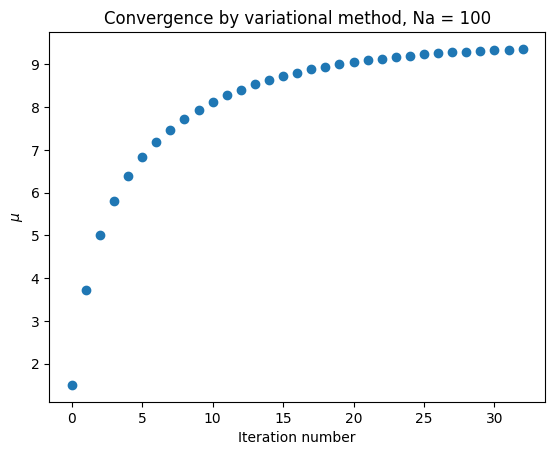

In [36]:
plt.scatter(range(i),mu_var_H_100[:i])
plt.title('Convergence by variational method, Na = 100')
xlabel('Iteration number')
ylabel(r'$\mu$')

Here we summarize our results, where the values of $\mu$ are reported up to the fifth significant figure.

|$Na$  | $\alpha$ | Iterations | $\mu$  |
| --- | --- | --- | --- |
| 0.01 | 0.1 | 21 | 1.5071 |
| 0.1 | 0.1 | 20 | 1.5674 |
| 1 | 0.1 | 35 | 2.5079 |
| 10 | 0.1 | 46 | 4.0081 |
| 100 | 0.1 | 33 | 9.3732 |

# 7) Solution of GP equation for a<0

In this final section we repeat the implementation of the variational method (already used in the previous part) in order to find out the optimal value of the parameter $ \mu $ and its dependence on the number of iterations. However, we now deal with negative values of the scattering length $ a $ (or equivalently with negative values of the free parameter $ Na $ since $ N $ is always a positive number). For each (negative) value of $ Na $, i.e. $ Na = -0.01, -0.1, -1, -10, -100 $ we use a fixed value of $ \alpha = 0.1 $. We clearly observe convergence for each value of Na, even if we obtain a value of $\mu$ which is very large in absolute value for $Na = 10, 100$. Therefore, we are not sure that the correct convergence is guaranteed in these last two cases.
Finally, we also observe that an additional difference between the case of positive and negative values of $ a $ lies in the fact that in the latter case the convergent results are reached by following a decreasing behavior of $ \mu $, so in an opposite way than the former case. Indeed, the potential is now attractive and attains negative values as the radial coordinate tends to zero, conversely to what we saw in the case of repulsive potential.

We summarize all the results obtained in the following table, considering our $ \mu $ data up to the fifth significant figure.

|$Na$  | Iterations | $\mu$  |
| --- | --- | --- |
| -0.01 |  100 | 1.4920 |
| -0.1 |  100 | 1.4155 |
| -1 | 120 | -9.1174 |
| -10 |  100 | -183.38 |
| -100 |  100 | -1925.0 |

## Case Na = -0.01

In [8]:
# Prima iterazione
S = 10
Na = -0.01
H1 = np.zeros([S,S],float)
alpha = 0.1
H_int1 = np.zeros([S,S],float)

H_kin_ext = np.zeros([S,S],float)  # matrice che contiene la parte cinetica e il potenziale armonico dell'Hamiltoniana complessiva
for m in range(S):
    for n in range(S):
            H_kin_ext[m,n] += element_kin1(m,n) + element_ext(m,n)

H0 = np.zeros([S,S],float)
for m in range(S):
    for n in range(S):
        H0[m,n] += element_kin1(m,n) + element_ext(m,n)
H0_autovalori, H0_autovettori = eigh(H0)
mu_var_H0 = H0_autovalori[0]
print('The eigenvalue of the harmonic oscillator ground state is', mu_var_H0)

for m in range(S):
    for n in range(S):
        H_int1[m,n] =  alpha * element_int1(m,n,v1_var,H0_autovettori)
    print(m)

H1 = H_kin_ext + 2*H_int1

H1_autovalori, H1_autovettori = eigh(H1)
mu_var_H1_001 = H1_autovalori[0]
print('After the first iteration we get mu =',mu_var_H1_001)

The eigenvalue of the harmonic oscillator ground state is 1.5
0
1
2
3
4
5
6
7
8
9
After the first iteration we get mu = 1.4992019728137804


In [9]:
N = 100
H = np.zeros([S,S],float)
H_int = np.zeros([S,S],float)
mu_var_H_001 = np.zeros(N,float)
mu_var_H_001[0] = mu_var_H0
mu_var_H_001[1] = mu_var_H1_001
H_autovettori = H1_autovettori

for i in range(2,N):
    for m in range(S):
        for n in range(S):
            H_int[m,n] = (1-alpha) * H_int1[m,n] + alpha * element_int1(m,n,v1_var,H_autovettori)
        print(m)
    H = H_kin_ext + 2*H_int
    H_autovalori, H_autovettori = eigh(H)
    
    mu_var_H_001[i] = H_autovalori[0]
    print(mu_var_H_001[i])
    H_int1 = H_int

print('After',i,'iterations we get mu =',mu_var_H_001[i])

0
1
2
3
4
5
6
7
8
9
1.498483218820893
0
1
2
3
4
5
6
7
8
9
1.4978358849426066
0
1
2
3
4
5
6
7
8
9
1.4972528919475194
0
1
2
3
4
5
6
7
8
9
1.496727858976635
0
1
2
3
4
5
6
7
8
9
1.4962550352805917
0
1
2
3
4
5
6
7
8
9
1.4958292385086245
0
1
2
3
4
5
6
7
8
9
1.495445798943679
0
1
2
3
4
5
6
7
8
9
1.4951005091294955
0
1
2
3
4
5
6
7
8
9
1.4947895783834613
0
1
2
3
4
5
6
7
8
9
1.4945095917336395
0
1
2
3
4
5
6
7
8
9
1.4942574728595364
0
1
2
3
4
5
6
7
8
9
1.4940304506543123
0
1
2
3
4
5
6
7
8
9
1.4938260290609933
0
1
2
3
4
5
6
7
8
9
1.4936419598673953
0
1
2
3
4
5
6
7
8
9
1.4934762181737968
0
1
2
3
4
5
6
7
8
9
1.4933269802741975
0
1
2
3
4
5
6
7
8
9
1.4931926037165453
0
1
2
3
4
5
6
7
8
9
1.4930716093294745
0
1
2
3
4
5
6
7
8
9
1.4929626650235008
0
1
2
3
4
5
6
7
8
9
1.4928645711929238
0
1
2
3
4
5
6
7
8
9
1.4927762475614919
0
1
2
3
4
5
6
7
8
9
1.4926967213299949
0
1
2
3
4
5
6
7
8
9
1.4926251164977404
0
1
2
3
4
5
6
7
8
9
1.4925606442422559
0
1
2
3
4
5
6
7
8
9
1.4925025942529078
0
1
2
3
4
5
6
7
8
9
1.492450

Text(0, 0.5, '$\\mu$')

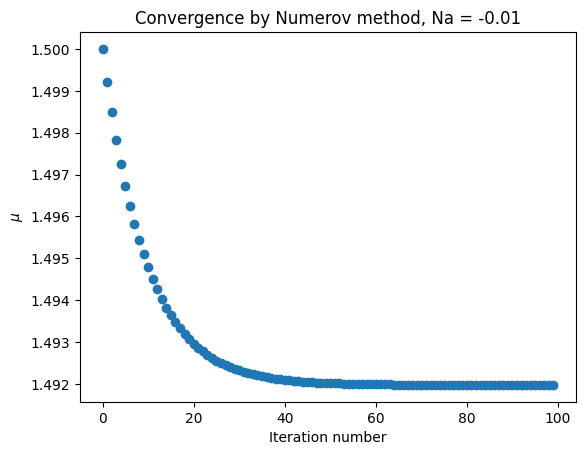

In [25]:
plt.scatter(range(N),mu_var_H_001[:])
plt.title("Convergence by Variational method, Na = -0.01")
xlabel("Iteration number")
ylabel(r'$\mu$')

## Case Na = -0.1

In [10]:
Na = -0.1
H1 = np.zeros([S,S],float)
alpha = 0.1
H_int1 = np.zeros([S,S],float)

for m in range(S):
    for n in range(S):
        H_int1[m,n] =  alpha * element_int1(m,n,v1_var,H0_autovettori)
    print(m)

H1 = H_kin_ext + 2*H_int1

H1_autovalori, H1_autovettori = eigh(H1)
mu_var_H1_01 = H1_autovalori[0]
print('After the first iteration we get mu =',mu_var_H1_01)

0
1
2
3
4
5
6
7
8
9
After the first iteration we get mu = 1.4920068926359054


In [11]:

H = np.zeros([S,S],float)
H_int = np.zeros([S,S],float)
mu_var_H_01 = np.zeros(N,float)
mu_var_H_01[0] = mu_var_H0
mu_var_H_01[1] = mu_var_H1_01
H_autovettori = H1_autovettori

for i in range(2,N):
    for m in range(S):
        for n in range(S):
            H_int[m,n] = (1-alpha) * H_int1[m,n] + alpha * element_int1(m,n,v1_var,H_autovettori)
        print(m)
    H = H_kin_ext + 2*H_int
    H_autovalori, H_autovettori = eigh(H)
    
    mu_var_H_01[i] = H_autovalori[0]
    print(mu_var_H_01[i])
    H_int1 = H_int


print('After',i,'iterations we get mu =',mu_var_H_01[i])

0
1
2
3
4
5
6
7
8
9
1.4847597987516161
0
1
2
3
4
5
6
7
8
9
1.4781909701332776
0
1
2
3
4
5
6
7
8
9
1.472238456345791
0
1
2
3
4
5
6
7
8
9
1.466845676719838
0
1
2
3
4
5
6
7
8
9
1.4619610100829814
0
1
2
3
4
5
6
7
8
9
1.457537404761715
0
1
2
3
4
5
6
7
8
9
1.453532010373625
0
1
2
3
4
5
6
7
8
9
1.4499058321555907
0
1
2
3
4
5
6
7
8
9
1.446623407988244
0
1
2
3
4
5
6
7
8
9
1.4436525078404947
0
1
2
3
4
5
6
7
8
9
1.4409638550395747
0
1
2
3
4
5
6
7
8
9
1.4385308685468725
0
1
2
3
4
5
6
7
8
9
1.436329425267367
0
1
2
3
4
5
6
7
8
9
1.4343376413245703
0
1
2
3
4
5
6
7
8
9
1.432535671180476
0
1
2
3
4
5
6
7
8
9
1.430905523460731
0
1
2
3
4
5
6
7
8
9
1.4294308923507646
0
1
2
3
4
5
6
7
8
9
1.4280970034524099
0
1
2
3
4
5
6
7
8
9
1.426890473027483
0
1
2
3
4
5
6
7
8
9
1.4257991796007772
0
1
2
3
4
5
6
7
8
9
1.424812146946799
0
1
2
3
4
5
6
7
8
9
1.423919437539978
0
1
2
3
4
5
6
7
8
9
1.4231120556050374
0
1
2
3
4
5
6
7
8
9
1.4223818589614112
0
1
2
3
4
5
6
7
8
9
1.421721478911954
0
1
2
3
4
5
6
7
8
9
1.421124247480895

Text(0, 0.5, '$\\mu$')

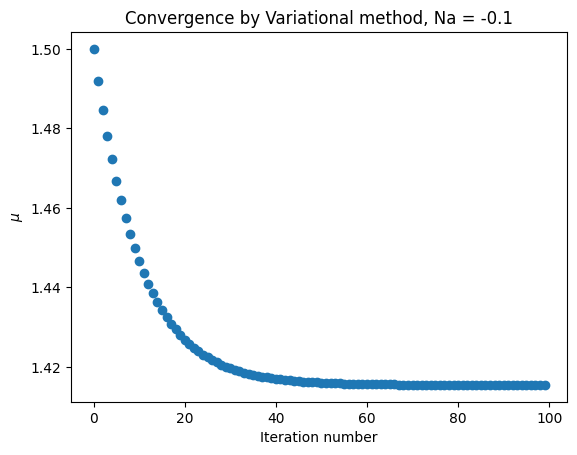

In [12]:
plt.scatter(range(N),mu_var_H_01)
plt.title("Convergence by Variational method, Na = -0.1")
xlabel("Iteration number")
ylabel(r'$\mu$')

## Case Na = -1

In [23]:
# Prima iterazione
Na = -1
H1 = np.zeros([S,S],float) # matrice Hamiltoniana
alpha = 0.1
H_int1 = np.zeros([S,S],float) # matrice del potenziale interno

for m in range(S): # riempio la matrice del potenziale interno
    for n in range(S):
        H_int1[m,n] +=  alpha * element_int1(m,n,v1_var,H0_autovettori)
    print(m)

H1 = H_kin_ext + 2*H_int1 # riempio l'Hamiltoniana

H1_autovalori, H1_autovettori = eigh(H1)  # Diagonalizzo l'Hamiltoniana
mu_var_H1 = H1_autovalori[0] # salvo l'autovalore più basso dopo la prima iterazione
print('After the first iteration we get mu =', mu_var_H1)

0
1
2
3
4
5
6
7
8
9
After the first iteration we get mu = 1.4187865968244011


In [24]:
N=120
H = np.zeros([S,S],float)
H_int = np.zeros([S,S],float)
mu_var_H_1 = np.zeros(N,float) # vettore dei valori di mu per ogni iterazione
mu_var_H_1[0] = mu_var_H0 # al primo posto metto l'autovalore dell'oscillatore armonico
mu_var_H_1[1] = mu_var_H1 # al secondo posto metto l'autovalore ottenuto dopo la prima iterazione
H_autovettori = H1_autovettori # alla seconda iterazione, il potenziale v1 = v_new lo costruisco con l'Hamiltoniana vecchia 

for i in range(2,N):
    for m in range(S):
        for n in range(S):
            H_int[m,n] = (1-alpha) * H_int1[m,n] + alpha * element_int1(m,n,v1_var,H_autovettori) # formula di mixing per il potenziale, all'inizio v0 = v_old è il potenziale ottenuto alla seconda iterazione
        print(m)
    H = H_kin_ext + 2*H_int
    H_autovalori, H_autovettori = eigh(H) # diagonalizzo l'Hamiltoniana complessiva
    
    mu_var_H_1[i] = H_autovalori[0] # salvo l'autovalore 
    print(mu_var_H_1[i])
    H_int1 = H_int # aggiorno il potenziale: come nel caso delle iterazioni con Numerov, questa riga corrisponde a porre v0 = v2


print('After',i,'iterations we get mu =',mu_var_H_1[i])

0
1
2
3
4
5
6
7
8
9
1.3400106261983866
0
1
2
3
4
5
6
7
8
9
1.2634424188128446
0
1
2
3
4
5
6
7
8
9
1.1888397264520596
0
1
2
3
4
5
6
7
8
9
1.1159492344218875
0
1
2
3
4
5
6
7
8
9
1.044507324815783
0
1
2
3
4
5
6
7
8
9
0.9742401656052196
0
1
2
3
4
5
6
7
8
9
0.9048631869737805
0
1
2
3
4
5
6
7
8
9
0.8360799933244459
0
1
2
3
4
5
6
7
8
9
0.7675807483740839
0
1
2
3
4
5
6
7
8
9
0.6990400628826007
0
1
2
3
4
5
6
7
8
9
0.6301144110831371
0
1
2
3
4
5
6
7
8
9
0.5604391043114545
0
1
2
3
4
5
6
7
8
9
0.4896248606904142
0
1
2
3
4
5
6
7
8
9
0.41725403066757205
0
1
2
3
4
5
6
7
8
9
0.34287657313601466
0
1
2
3
4
5
6
7
8
9
0.26600592989870125
0
1
2
3
4
5
6
7
8
9
0.1861150220803438
0
1
2
3
4
5
6
7
8
9
0.10263269471169778
0
1
2
3
4
5
6
7
8
9
0.014941068808159486
0
1
2
3
4
5
6
7
8
9
-0.07762557829820693
0
1
2
3
4
5
6
7
8
9
-0.17577960121623448
0
1
2
3
4
5
6
7
8
9
-0.2802754573927686
0
1
2
3
4
5
6
7
8
9
-0.39190072906463413
0
1
2
3
4
5
6
7
8
9
-0.5114615135353553
0
1
2
3
4
5
6
7
8
9
-0.6397611206633194
0
1
2
3
4
5

Text(0, 0.5, '$\\mu$')

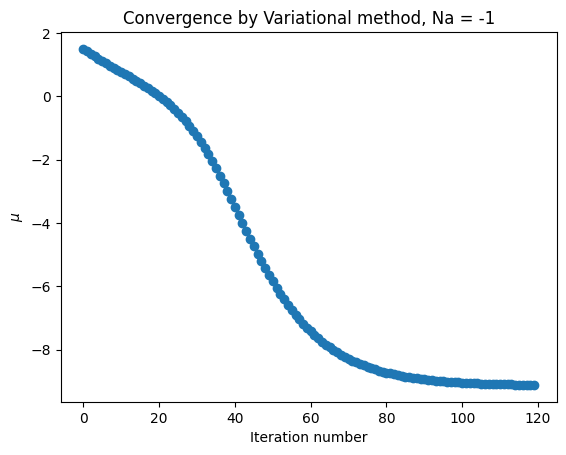

In [25]:
plt.scatter(range(N),mu_var_H_1[:])
plt.title("Convergence by Variational method, Na = -1")
xlabel("Iteration number")
ylabel(r'$\mu$')

## Case Na = -10

In [16]:
# Prima iterazione

Na = -10
H1 = np.zeros([S,S],float)
alpha = 0.1
H_int1 = np.zeros([S,S],float)

for m in range(S):
    for n in range(S):
        H_int1[m,n] =  alpha * element_int1(m,n,v1_var,H0_autovettori)
    print(m)

H1 = H_kin_ext + 2*H_int1

H1_autovalori, H1_autovettori = eigh(H1)
mu_var_H1_10 = H1_autovalori[0]
print('After the first iteration we get mu =',mu_var_H1_10)

0
1
2
3
4
5
6
7
8
9
After the first iteration we get mu = 0.5646232083098068


In [17]:

H = np.zeros([S,S],float)
H_int = np.zeros([S,S],float)
mu_var_H_10 = np.zeros(N,float)
mu_var_H_10[0] = mu_var_H0
mu_var_H_10[1] = mu_var_H1_10
H_autovettori = H1_autovettori

for i in range(2,N):
    for m in range(S):
        for n in range(S):
            H_int[m,n] = (1-alpha) * H_int1[m,n] + alpha * element_int1(m,n,v1_var,H_autovettori)
        print(m)
    H = H_kin_ext + 2*H_int
    H_autovalori, H_autovettori = eigh(H)
    
    mu_var_H_10[i] = H_autovalori[0]
    print(mu_var_H_10[i])
    H_int1 = H_int


print('After',i,'iterations we get mu =',mu_var_H_10[i])

0
1
2
3
4
5
6
7
8
9
-1.25094673331785
0
1
2
3
4
5
6
7
8
9
-5.764895184668621
0
1
2
3
4
5
6
7
8
9
-15.805750125312258
0
1
2
3
4
5
6
7
8
9
-29.566544571931075
0
1
2
3
4
5
6
7
8
9
-43.67665001298386
0
1
2
3
4
5
6
7
8
9
-56.98379806105113
0
1
2
3
4
5
6
7
8
9
-69.22422383043039
0
1
2
3
4
5
6
7
8
9
-80.37612891514601
0
1
2
3
4
5
6
7
8
9
-90.49098649850653
0
1
2
3
4
5
6
7
8
9
-99.64328784048645
0
1
2
3
4
5
6
7
8
9
-107.91291780706253
0
1
2
3
4
5
6
7
8
9
-115.37828129670916
0
1
2
3
4
5
6
7
8
9
-122.1135199655943
0
1
2
3
4
5
6
7
8
9
-128.18745726213768
0
1
2
3
4
5
6
7
8
9
-133.66332729699886
0
1
2
3
4
5
6
7
8
9
-138.59887296178246
0
1
2
3
4
5
6
7
8
9
-143.04661778135366
0
1
2
3
4
5
6
7
8
9
-147.05421424733598
0
1
2
3
4
5
6
7
8
9
-150.6648184749131
0
1
2
3
4
5
6
7
8
9
-153.91746484420688
0
1
2
3
4
5
6
7
8
9
-156.8474268641426
0
1
2
3
4
5
6
7
8
9
-159.48655736074792
0
1
2
3
4
5
6
7
8
9
-161.86360492606585
0
1
2
3
4
5
6
7
8
9
-164.0045057322581
0
1
2
3
4
5
6
7
8
9
-165.93265104031357
0
1
2
3
4
5
6

Text(0, 0.5, '$\\mu$')

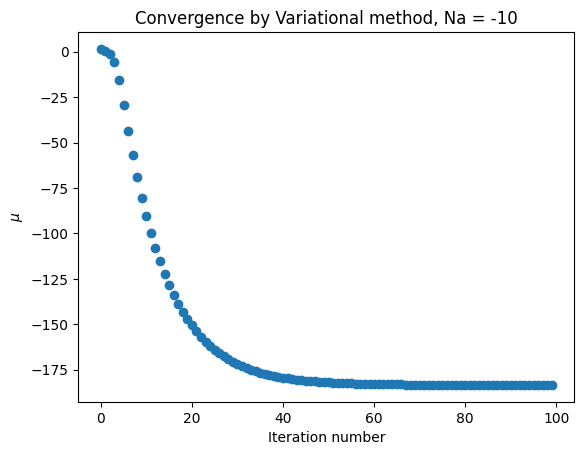

In [22]:
plt.scatter(range(N),mu_var_H_10[:])
plt.title("Convergence by Variational method, Na = -10")
xlabel("Iteration number")
ylabel(r'$\mu$')

## Case Na = -100

In [19]:
# Prima iterazione

Na = -100
H1 = np.zeros([S,S],float)
alpha = 0.1
H_int1 = np.zeros([S,S],float)

for m in range(S):
    for n in range(S):
        H_int1[m,n] =  alpha * element_int1(m,n,v1_var,H0_autovettori)
    print(m)

H1 = H_kin_ext + 2*H_int1

H1_autovalori, H1_autovettori = eigh(H1)
mu_var_H1_100 = H1_autovalori[0]
print('After the first iteration we get mu =',mu_var_H1_100)

0
1
2
3
4
5
6
7
8
9
After the first iteration we get mu = -13.232155402983448


In [20]:

H = np.zeros([S,S],float)
H_int = np.zeros([S,S],float)
mu_var_H_100 = np.zeros(N,float)
mu_var_H_100[0] = mu_var_H0
mu_var_H_100[1] = mu_var_H1_100
H_autovettori = H1_autovettori

for i in range(2,N):
    for m in range(S):
        for n in range(S):
            H_int[m,n] = (1-alpha) * H_int1[m,n] + alpha * element_int1(m,n,v1_var,H_autovettori)
        print(m)
    H = H_kin_ext + 2*H_int
    H_autovalori, H_autovettori = eigh(H)
    
    mu_var_H_100[i] = H_autovalori[0]
    print(mu_var_H_100[i])
    H_int1 = H_int


print('After',i,'iterations we get mu =',mu_var_H_100[i])

0
1
2
3
4
5
6
7
8
9
-133.19210041725694
0
1
2
3
4
5
6
7
8
9
-307.9361871534905
0
1
2
3
4
5
6
7
8
9
-468.65616262191594
0
1
2
3
4
5
6
7
8
9
-613.8756761142586
0
1
2
3
4
5
6
7
8
9
-744.76664493341
0
1
2
3
4
5
6
7
8
9
-862.6563684394573
0
1
2
3
4
5
6
7
8
9
-968.8040451387678
0
1
2
3
4
5
6
7
8
9
-1064.364741935141
0
1
2
3
4
5
6
7
8
9
-1150.3870442178752
0
1
2
3
4
5
6
7
8
9
-1227.8189659270395
0
1
2
3
4
5
6
7
8
9
-1297.5159662367003
0
1
2
3
4
5
6
7
8
9
-1360.2492263130673
0
1
2
3
4
5
6
7
8
9
-1416.7135674850347
0
1
2
3
4
5
6
7
8
9
-1467.5348040877868
0
1
2
3
4
5
6
7
8
9
-1513.2764783726109
0
1
2
3
4
5
6
7
8
9
-1554.4459863281488
0
1
2
3
4
5
6
7
8
9
-1591.5001279962253
0
1
2
3
4
5
6
7
8
9
-1624.8501249825867
0
1
2
3
4
5
6
7
8
9
-1654.8661500108615
0
1
2
3
4
5
6
7
8
9
-1681.8814123433299
0
1
2
3
4
5
6
7
8
9
-1706.1958404522152
0
1
2
3
4
5
6
7
8
9
-1728.0794003164856
0
1
2
3
4
5
6
7
8
9
-1747.7750845592664
0
1
2
3
4
5
6
7
8
9
-1765.5016045373582
0
1
2
3
4
5
6
7
8
9
-1781.4558145472968
0
1
2
3


Text(0, 0.5, '$\\mu$')

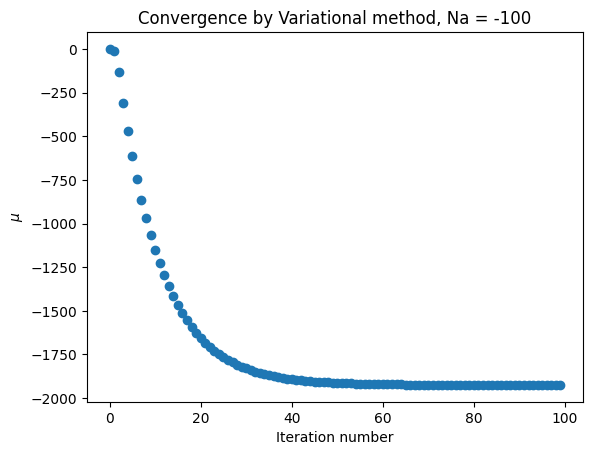

In [21]:
plt.scatter(range(N),mu_var_H_100)
plt.title("Convergence by Variational method, Na = -100")
xlabel("Iteration number")
ylabel(r'$\mu$')